In [1]:
import os
import copy
import re
import psignifit as ps
import glob
# import pickle as pkl
import dill as pkl
import numpy as np
import pylab as pl
import seaborn as sns
import scipy.stats as spstats
import pandas as pd
import importlib

import scipy as sp
import itertools
import matplotlib as mpl
import matplotlib.patches as patches
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)                 
# /n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit  

In [2]:
# import functools3 as p3
import py3utils as p3
import plotting as pplot
import rf_utils as rfutils

In [3]:
from psignifit import getSigmoidHandle as getSig
from psignifit import getStandardParameters


In [4]:
#set_plot_params()
visual_areas, area_colors = pplot.set_threecolor_palette() 

In [5]:
%matplotlib notebook

In [6]:
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir = '/n/coxfs01/2p-data'
traceid = 'traces001'
response_type='dff'
responsive_test='ROC'
responsive_thr = 0.05 if responsive_test=='ROC' else 10.0
trial_epoch = 'plushalf'
overlap_thr=None
overlap_str = 'noRF' if overlap_thr in [None, 'None'] else 'overlap-%.2f' % overlap_thr

fov_type = 'zoom2p0x'
state = 'awake'
src_data_dir = os.path.join(aggregate_dir, 'data-stats', 'tmp_data')

In [7]:
fname = 'neuraldata_%s_%s_%s-thr-%.2f_%s_%s' \
        % (traceid, response_type, responsive_test, responsive_thr, trial_epoch, overlap_str)

src_datafile = os.path.join(src_data_dir, '%s.pkl' % fname)
print(src_datafile)

/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/tmp_data/neuraldata_traces001_dff_ROC-thr-0.05_plushalf_noRF.pkl


# Load source data

In [8]:
data_id = os.path.splitext(os.path.split(src_datafile)[-1])[0]

In [9]:
trial_epoch='plushalf'
experiment='blobs'
with open(src_datafile, 'rb') as f:
    D = pkl.load(f, encoding='latin1')
# D.keys()
DATA = D['DATA']
sdata = D['sdata']
SDF = D['SDF']
# selective_df = D['selective_df']
# del D

make_dataframes=False

In [10]:
importlib.reload(p3)

<module 'py3utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/py3utils.py'>

In [11]:
if make_dataframes:
    NDATA = p3.get_aggregate_data(experiment, traceid=traceid, 
                          response_type=response_type, epoch=trial_epoch,
                          responsive_test=responsive_test, 
                          responsive_thr=responsive_thr, n_stds=responsive_thr)


    sdata, cells0 = p3.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
    meta = sdata[sdata.experiment.isin([experiment])].copy()
    all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]
    CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                                      if (va, dk) in all_dkeys])
    CELLS[['visual_area', 'animalid', 'session', 'fovnum']]\
                .drop_duplicates().groupby(['visual_area']).count()

    # Load RF data
    do_spherical_correction=False
    rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                       do_spherical_correction=do_spherical_correction)
    rf_meta = sdata[sdata.experiment.isin(['rfs', 'rfs10'])].copy()
    rfdata = rfutils.aggregate_rfdata(rf_meta, CELLS, fit_desc=rf_fit_desc)
    # Get ROI positions
    rfdata = p3.add_rf_positions(rfdata)
    rf_dkeys = [(va, dk) for (va, dk), g in rf_meta.groupby(['visual_area', 'datakey'])]
    rfCELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                                      if (va, dk) in rf_dkeys])

    DATA, RFDATA =  p3.get_common_cells_from_dataframes(NDATA, rfdata)

    SDF={}
    for (va, dk), g in DATA.groupby(['visual_area', 'datakey']):
        sdf = p3.get_stimuli(dk, experiment)
        SDF[dk] = sdf

    R = {'SDF':SDF, 'CELLS':CELLS, 'DATA':DATA, 'sdata':sdata, 'RFDATA':RFDATA}

    with open(src_datafile, 'wb') as f:
        pkl.dump(R, f, protocol=2) #encoding='latin1')

## Calculate selectivity index

In [12]:
def sel_or_no(sd_, class_a=0, class_b=106, p_thr=0.05):
    a_vals = sd_[(sd_['morphlevel']==class_a)].sort_values(by='trial')['response'].values
    b_vals = sd_[(sd_['morphlevel']==class_b)].sort_values(by='trial')['response'].values
    t, p = spstats.mannwhitneyu(a_vals, b_vals)
    return p<p_thr

def is_selective(rdf, p_thr=0.05, class_a=0, class_b=106):
    return any(rdf.groupby(['size']).apply(sel_or_no, class_a=class_a, class_b=class_b, p_thr=p_thr))


In [13]:
diff_configs = ['20190314_JC070_fov1']
class_a=0; class_b=106;
verbose=True
selective_only = True
if selective_only:
    d_=[]
    for (va, dk), ndf in DATA.groupby(['visual_area', 'datakey']):
        if dk in diff_configs:
            continue
        sdf = SDF[dk].copy()
        ndf['size'] = [sdf['size'][c] for c in ndf['config']]
        ndf['morphlevel'] = [sdf['morphlevel'][c] for c in ndf['config']]
        # Get cells selective to A or B (Mann-Whitney U test)
        s0 = ndf[ndf.morphlevel.isin([class_a, class_b])].groupby(['cell']).apply(is_selective)
        selective_cells = s0[s0==True].index.tolist()
        if verbose:
            print("... (%s) %i of %i cells selective" % (dk, len(selective_cells), len(ndf['cell'].unique())))
        # For selctive cells, calculate selectivity index (-1=prefers B, +1=prefers A)
        selective_ = ndf[ndf['cell'].isin(selective_cells)].copy()
        mean_anchors = selective_[selective_.morphlevel.isin([class_a, class_b])]\
                    .groupby(['visual_area', 'datakey', 'cell', 'size', 'morphlevel'])\
                    .mean().reset_index()
        a_vals = mean_anchors[mean_anchors.morphlevel==class_a]['response'].values
        b_vals = mean_anchors[mean_anchors.morphlevel==class_b]['response'].values
        sel_ixs = (a_vals - b_vals) / (a_vals+b_vals)
        df_ = mean_anchors[['visual_area', 'datakey', 'cell', 'size']].drop_duplicates()
        assert df_.shape[0]==len(sel_ixs), "Bad column drop..."
        df_['sel_ix'] = sel_ixs
        d_.append(df_)
    selective_df = pd.concat(d_).reset_index(drop=True)
    selective_df.head()

... (20190315_JC070_fov1) 19 of 27 cells selective
... (20190316_JC070_fov1) 4 of 7 cells selective
... (20190319_JC067_fov1) 1 of 4 cells selective
... (20190320_JC067_fov1) 0 of 1 cells selective
... (20190321_JC070_fov1) 1 of 1 cells selective
... (20190322_JC073_fov1) 26 of 38 cells selective
... (20190327_JC073_fov1) 16 of 27 cells selective
... (20190422_JC076_fov1) 22 of 29 cells selective
... (20190602_JC091_fov1) 77 of 87 cells selective
... (20190606_JC091_fov1) 34 of 48 cells selective
... (20190607_JC091_fov1) 28 of 52 cells selective
... (20190609_JC099_fov1) 34 of 57 cells selective
... (20190612_JC099_fov1) 20 of 38 cells selective
... (20190614_JC091_fov1) 35 of 78 cells selective
... (20190617_JC099_fov1) 7 of 7 cells selective
... (20191018_JC113_fov1) 27 of 47 cells selective
... (20191105_JC117_fov1) 25 of 67 cells selective
... (20191111_JC120_fov1) 11 of 30 cells selective
... (20190322_JC073_fov1) 20 of 30 cells selective
... (20190327_JC073_fov1) 4 of 6 cells se

In [14]:
# selective_df['Eff'] = None
# selective_df.loc[ selective_df['sel_ix']<0, 'Eff'] = 'B'
# selective_df.loc[ selective_df['sel_ix']>0, 'Eff'] = 'A'


# Params

In [14]:
import neurometric as pneuro
import neurometric_fits as pn2

NoneType: None


In [15]:
#### Set params
single_eff=True
sigmoid='gauss'
allow_negative=True

sigmoid_dir = '%s_reverse' % sigmoid if not allow_negative else sigmoid
print(sigmoid_dir)
param = 'morphlevel'

class_a=0
class_b=106
criterion = 0.7

fitopts = pneuro.default_options()

gauss


# Output dir

In [16]:
dst_dir = os.path.join(aggregate_dir, 'blobs-tuning', 'neurometric_curves',
                       'psignifit', 'fit_%s_selective__%s' % (sigmoid_dir, param))
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)
os.listdir(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/fit_gauss_selective__morphlevel


['examples',
 'stripplot_auc_selective-crit-0.70.svg',
 'V1_fits.svg',
 'Li_fits.svg',
 'V1_fits_pref50.svg',
 'V1_fits_pref106.svg',
 'split_pupil',
 'V1_fits_pref0.svg',
 'Lm_fits_pref0.svg',
 'Li_fits_pref0.svg',
 'Lm_fits_pref106.svg',
 'Li_fits_pref106.svg',
 '_V1_fits_pref0.svg',
 '_Lm_fits_pref0.svg',
 '_Li_fits_pref0.svg',
 '_V1_fits_pref106.svg',
 '_Lm_fits_pref106.svg',
 '_Li_fits_pref106.svg',
 '_JNDs.svg',
 '.__Li_fits_pref106.svg',
 'aggregate_curves_hueAB_subsampled.svg']

# Load aggregate AUC

In [17]:
importlib.reload(pn2)

NoneType: None


<module 'neurometric_fits' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/neurometric_fits.py'>

In [18]:
selective_only=False
single_eff=True
allow_negative=True
if param=='morphstep':
    single_eff=False
    allow_negative=False
#### Load AUC 
if selective_only:
    sel_df = selective_df.copy()
else:
    sel_df=None
# AUC = pneuro.load_aggregate_AUC(param=param, allow_negative=allow_negative,
#                                 selective_only=selective_only, 
#                                 selective_df=sel_df, 
#                                 single_eff=single_eff)
AUC = pn2.aggregate_AUC(DATA, SDF, param=param, allow_negative=allow_negative,
                  selective_only=selective_only, selective_df=selective_only, 
                  create_new=False, single_eff=single_eff)
if param=='morphlevel':
    if 'object' not in AUC.columns:
        AUC['object'] = 'M'
        AUC.loc[AUC['morphlevel']<53, 'object'] = 'A'
        AUC.loc[AUC['morphlevel']>53, 'object'] = 'B'

/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/tmp_data/morphlevel_AUC_single.pkl
SINGLE: True
   cell  level_1  index       AUC  morphlevel  size  Eff  n_trials  \
0   113        0      0  0.551111           0  10.0  106        30   
1   113        1      1  0.500000          14  10.0  106        30   
2   113        2      2  0.545556          27  10.0  106        30   
3   113        3      3  0.487778          40  10.0  106        30   
4   113        4      4  0.601111          53  10.0  106        30   

  visual_area              datakey object  
0          Li  20190315_JC070_fov1      A  
1          Li  20190315_JC070_fov1      A  
2          Li  20190315_JC070_fov1      A  
3          Li  20190315_JC070_fov1      A  
4          Li  20190315_JC070_fov1      M  


In [19]:
#### Only select cells with min. response > crit
criterion = 0.7
sdf = SDF['20190522_JC084_fov1'].copy() # Just pick a dset w standard cfgs
morphlevels = [i for i in sorted(sdf['morphlevel'].unique()) if i!=-1]
anchors_ = [i for ii in [morphlevels[0:2], morphlevels[-2:]] for i in ii]
max_level = 4 if param=='morphstep' else 1
if param=='morphlevel':
    pAUC_anchors = AUC[(AUC['morphlevel'].isin(anchors_)) & (AUC['AUC']>=criterion)].copy()
else:
    pAUC_anchors = AUC[(AUC['AUC']>=criterion)].copy()
print(pAUC_anchors.shape)
# pAUC = pd.concat([g for (va, dk, c), g in AUC.groupby(['visual_area', 'datakey', 'cell']) \
#                   if g['AUC'].max()>=criterion])
passkeys = list([tuple(k) for k in \
                 pAUC_anchors[['visual_area', 'datakey', 'cell']]\
                 .drop_duplicates().values])
pAUC = pd.concat([g for (v,k,r), g in AUC.groupby(['visual_area', 'datakey', 'cell'])\
                 if (v, k, r) in passkeys])

print("Total N cells fit:")
print(AUC[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())
print("N cells pass (crit=%.2f):" % criterion)
print(pAUC_anchors[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())

(2344, 11)
Total N cells fit:
             datakey  cell
visual_area               
Li               644   644
Lm              1101  1101
V1              1251  1251
N cells pass (crit=0.70):
             datakey  cell
visual_area               
Li               219   219
Lm               401   401
V1               610   610


In [20]:
selective_only=True
selective_str = 'selective' if selective_only else "allcells"
if selective_only:
    print("... getting SELECTIVE only")
    s_=[] 
    # pAUC_anchors only?
    for (va, dk), g in pAUC_anchors.groupby(['visual_area', 'datakey']):
        curr_cells_auc = g['cell'].unique()
        curr_cells_sel = selective_df[(selective_df.visual_area==va) 
                                    & (selective_df.datakey==dk)]['cell'].unique()
        sel_and_auc = np.intersect1d(curr_cells_auc, curr_cells_sel)
        s_.append(g[g['cell'].isin(sel_and_auc)])
    pSEL = pd.concat(s_, axis=0).reset_index(drop=True)
else:
    pSEL = pAUC.copy()
    
print(pSEL[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())


... getting SELECTIVE only
             datakey  cell
visual_area               
Li               154   154
Lm               297   297
V1               536   536


In [21]:
meanAUC = pSEL.groupby(['visual_area', 'datakey', 'cell', 'Eff']).mean().reset_index()
meanAUC.head()

visual_area              datakey  cell  Eff  level_1  index       AUC  \
0          Li  20190315_JC070_fov1   113  106     13.0  18.25  0.760000   
1          Li  20190315_JC070_fov1   138  106     22.0  32.50  0.733889   
2          Li  20190315_JC070_fov1   152  106     26.0  23.00  0.721111   
3          Li  20190315_JC070_fov1   183  106     26.0  23.00  0.776667   
4          Li  20190315_JC070_fov1   187  106     16.5  14.50  0.761111   

   morphlevel  size  n_trials  
0        53.0  20.0      30.0  
1        53.0  30.0      30.0  
2       106.0  30.0      30.0  
3       106.0  30.0      30.0  
4        99.0  20.0      30.0

<IPython.core.display.Javascript object>


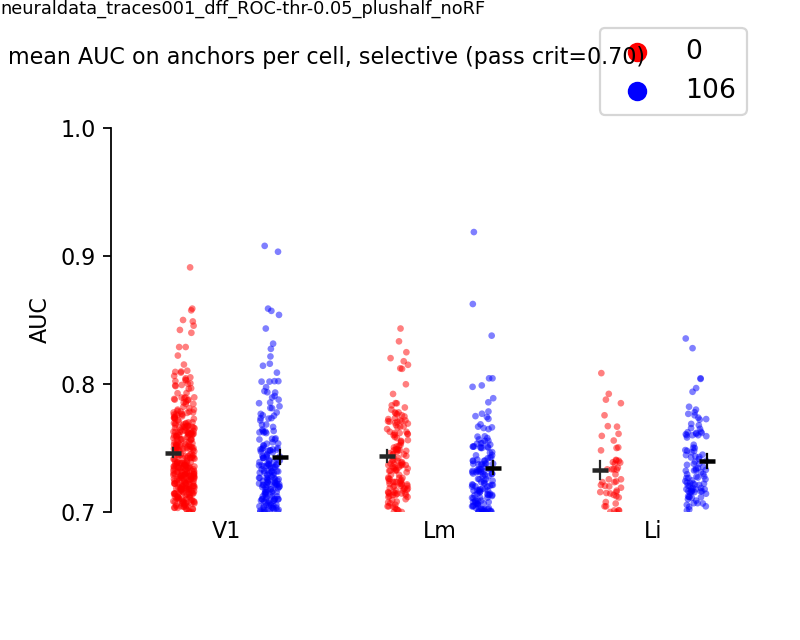

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/fit_gauss_selective__morphlevel stripplot_auc_selective-crit-0.70


In [22]:
object_colors = {'A': 'r', 'B': 'b', 0:'r', 106: 'b'}
visual_areas=['V1', 'Lm', 'Li']

fig, ax = pl.subplots(figsize=(5,4), dpi=100)
sns.stripplot(x='visual_area', y='AUC', hue='Eff', data=meanAUC, ax=ax, zorder=-1,
             dodge=0.5, palette=object_colors, alpha=0.5,size=3, order=visual_areas)

sns.pointplot(x='visual_area', y='AUC', hue='Eff', data=meanAUC, ax=ax,
             join=False, dodge=0.5, color='k', markers='_', order=visual_areas,
             zorder=-1, scale=1, errwidth=1)
ax.set_ylim((.7, 1.))
ax.set_yticks(np.linspace(0.7, 1, 4))
ax.tick_params(which='both', axis='x', size=0)
sns.despine(trim=True, offset=4, bottom=True)
ax.set_xlabel('')
fig.text(0.01, 0.9, 'mean AUC on anchors per cell, %s (pass crit=%.2f)' % (selective_str, criterion))
pplot.crop_legend_labels(ax, n_hues=2, bbox_to_anchor=(1,1), loc='lower right')
pl.subplots_adjust(left=0.15, right=0.95, bottom=0.2, top=0.8)

pplot.label_figure(fig, data_id)

figname = 'stripplot_auc_%s-crit-%.2f' % (selective_str, criterion)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [23]:
meanAUC[['visual_area', 'datakey', 'cell']].drop_duplicates()\
    .groupby(['visual_area', 'datakey']).count()

cell
visual_area datakey                  
Li          20190315_JC070_fov1    11
            20190316_JC070_fov1     1
            20190322_JC073_fov1     7
            20190422_JC076_fov1     9
            20190602_JC091_fov1    55
            20190606_JC091_fov1    13
            20190607_JC091_fov1    11
            20190609_JC099_fov1    13
            20190612_JC099_fov1     7
            20190614_JC091_fov1    13
            20190617_JC099_fov1     5
            20191018_JC113_fov1     2
            20191105_JC117_fov1     3
            20191111_JC120_fov1     4
Lm          20190322_JC073_fov1    12
            20190422_JC076_fov1     7
            20190430_JC078_fov1    25
            20190504_JC078_fov1     9
            20190506_JC080_fov1    43
            20190508_JC083_fov1    36
            20190509_JC078_fov1     5
            20190512_JC083_fov1    22
            20190513_JC078_fov1    25
            20190517_JC083_fov1    24
            20190525_JC084_fov1    33
            20190603_JC080_fov1    29
            20190618_JC097_fov1    11
            20190627_JC091_fov1    15
            20191105_JC117_fov1     1
V1          20190420_JC076_fov1     2
            20190501_JC076_fov1    14
            20190504_JC078_fov1    10
            20190507_JC083_fov1    46
            20190508_JC083_fov1    10
            20190509_JC078_fov1     4
            20190510_JC083_fov1    26
            20190511_JC083_fov1    35
            20190512_JC083_fov1     5
            20190517_JC083_fov1     3
            20190522_JC084_fov1    55
            20190613_JC097_fov1    53
            20190616_JC097_fov1    77
            20190617_JC097_fov1    81
            20190622_JC085_fov1    93
            20191006_JC110_fov1    22

# Load aggregate fits

In [24]:
pAUC['visual_area'].unique()

array(['Li', 'Lm', 'V1'], dtype=object)

In [25]:
importlib.reload(pneuro)

<module 'neurometric' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/neurometric.py'>

In [26]:
if param=='morphstep':
    allow_negative=False
    single_eff=False
print("Allow negative? %s" % allow_negative)
missing={}
r_=[]
for (va, dk), g in \
    pSEL.groupby(['visual_area', 'datakey']):
    #print(va, dk)
    curr_fits, curr_miss = pneuro.load_fitparams(dk, roi_list=g['cell'].unique(),
                                 param=param, 
                                 allow_negative=True, 
                                 sigmoid=sigmoid, split_pupil=False,
                                 return_dicts=False, return_missing=True)
    r_.append(curr_fits)
    if len(curr_miss)>0:
        missing[(va, dk)] = curr_miss
roifits = pd.concat(r_).reset_index(drop=True)
roifits.shape

Allow negative? True


(4715, 11)

In [27]:
roifits.head()

threshold     width        lambda  gamma           eta     slope       thr  \
0   1.157097  0.236855  3.059867e-07    0.5  5.367354e-08  2.770476  1.157098   
1  -0.108888  0.242261  2.493871e-01    0.5  7.471462e-08   0.02589   0.09835   
2   1.097250  0.244393  1.207297e-05    0.5  3.871372e-07  2.684963  1.097253   
3   1.096352  0.242481  1.025998e-06    0.5  5.574292e-05  2.706198  1.096352   
4   1.097603  0.242652  2.704861e-04    0.5  8.419415e-08  2.702826  1.097653   

   size  cell visual_area              datakey  
0  10.0   113          Li  20190315_JC070_fov1  
1  20.0   113          Li  20190315_JC070_fov1  
2  30.0   113          Li  20190315_JC070_fov1  
3  40.0   113          Li  20190315_JC070_fov1  
4  50.0   113          Li  20190315_JC070_fov1

In [28]:
print(selective_df[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())
print(roifits[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())


             datakey  cell
visual_area               
Li               387   387
Lm               717   717
V1               979   979
             datakey  cell
visual_area               
Li               154   154
Lm               278   278
V1               503   503


In [29]:
# for (va, dk, ci, sz), g in onefit.groupby(['visual_area', 'datakey', 'cell', 'size']):
#     eff = int(g['Eff'].unique())
#     opts['sigmoidName'] = 'neg_%s' % sigmoid if (eff==0 and allow_negative) else sig
#     fh = getSig.getSigmoidHandle(opts)
#     fvs = pneuro.get_fit_values(g, fh, xmin=0, xmax=max_level, npoints=50)

NameError: name 'onefit' is not defined

## Example traces and curves

In [131]:

def smooth_timecourse(in_trace, win_size=41):
    #smooth trace
    win_half = int(round(win_size/2))
    trace_pad = np.pad(in_trace, ((win_half, win_half)), 'reflect') # 'symmetric') #'edge')

    smooth_trace = np.convolve(trace_pad, np.ones((win_size,))*(1/float(win_size)),'valid')
    
    return smooth_trace

def smooth_traces_trial(gg, win_size=5, colname='trial'):
    smoothed_ = smooth_timecourse(gg, win_size=win_size)
    return pd.Series(smoothed_)

In [123]:
importlib.reload(p3)

<module 'py3utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/py3utils.py'>

In [161]:
rootdir = '/n/coxfs01/2p-data'
va='Lm'
dk = '20190627_JC091_fov1'
rid = 163

# va='Lm'
# dk ='20190504_JC078_fov1'
# rid = 194
# va='V1'
# dk = '20190507_JC083_fov1'
# rid = 8

session, animalid, fovn = p3.split_datakey_str(dk)
traces, labels = p3.load_corrected_dff_traces(animalid, session, 'FOV%i_zoom2p0x' % fovn, 
                                        return_traces=True, return_labels=True)

stim_on_frame = labels['stim_on_frame'].unique()[0]
nframes_on = labels['nframes_on'].unique()[0]
stim_on_sec = round(stim_on_frame/44.65, 1)

... calculating F0 for df/f


In [162]:
with_lum = False
lum_str = '_wLUM' if with_lum else ''

sdf = SDF[dk].copy()
if with_lum:
    curr_cfgs = sdf.index.tolist()
else:
    curr_cfgs = sdf[sdf['morphlevel']!=-1].index.tolist()
sizes = list(sorted(sdf['size'].unique()))
morphlevels = list(sorted(sdf.loc[curr_cfgs]['morphlevel'].unique()))

rtraces = labels.copy()
rtraces['dff'] = traces[rid].copy()
currt = rtraces[rtraces.config.isin(curr_cfgs)].copy()
currt['size'] = sdf.loc[currt['config']]['size'].values
currt['morphlevel'] = sdf.loc[currt['config']]['morphlevel'].values

In [163]:
morphlevels
if with_lum:
    M = morphlevels[1:]
    M.append(morphlevels[0])
else:
    M = morphlevels
print(M)

[0, 14, 27, 40, 53, 66, 79, 92, 106]


<IPython.core.display.Javascript object>


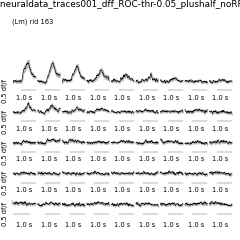

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/fit_gauss_selective__morphlevel/examples traces_Lm_20190627_JC091_fov1_cell163


In [164]:
curr_roi_col = 'k'
fill_sem=True
mean_only=False
ls='-'
fig, axn = pl.subplots(5, len(morphlevels), figsize=(3, 3), sharex=True, sharey=True)
for (sz, mp), g in currt.groupby(['size', 'morphlevel']):
    si = sizes[::-1].index(sz)
    mi = M.index(mp)
    ax=axn[si, mi]
    ax.patch.set(alpha=0)

    t_df = g.groupby(['trial'])['dff'].apply(smooth_traces_trial, win_size=5).unstack().T
    mean_t = np.nanmean(t_df, axis=1)
    std_t = np.nanstd(t_df, axis=1)
    sem_t = spstats.sem(t_df, axis=1, nan_policy='omit')

    if not mean_only:
        if fill_sem:
            #ax.fill_between(np.arange(0, len(mean_t)), mean_t-std_t, mean_t+std_t, alpha=0.2, color='k')
            ax.fill_between(np.arange(0, len(mean_t)), 
                            mean_t-sem_t, mean_t+sem_t, alpha=0.2, color='k')
        else:
            ax.plot(t_df, lw=0.1, color='gray', alpha=1) #'k')
    ax.plot(mean_t, lw=.5, c='k', linestyle=ls) #, label='%s %i' % (hue_, curr_hue))
    # format
    if not (mi==0 and si==len(sizes)-1):
        ax.set_xticks([stim_on_frame, stim_on_frame+nframes_on*2])
        ax.tick_params(which='both', axis='both', size=0)
        ax.set_xticklabels([])
        ax.set_yticks([])
        sns.despine(trim=True, ax=ax, left=True) 
        
    else:
        sns.despine(trim=True, ax=ax) #, bottom=True, left=True, ax=ax)
    ax.set_xticks([stim_on_frame, stim_on_frame+nframes_on*2])
    ax.tick_params(which='both', axis='both', size=0)
    ax.set_xticklabels([])
    ax.set_yticks([0.0, 0.1, 0.5])
    ax.set_yticklabels(['', '0.5 df/f', ''], rotation=90)
    ax.set_xlabel('%s s' % (stim_on_sec))
    ax.set_ylim([0.0, 0.7])
#sns.despine(trim=True, offset=0.2)
pl.subplots_adjust(left=0.05, right=0.97, wspace=0, hspace=-.5)
fig.text(0.05, 0.9, '(%s) rid %i' \
             % (va, rid), color=curr_roi_col)
    
p3.label_figure(fig, '%s|%s - %s' % (data_id, va, dk))

figname = 'traces%s_%s_%s_cell%03d' % (lum_str, va, dk, rid)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [139]:
curr_dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/fit_gauss_selective__morphlevel/examples'

#### Example FOV, quick fit cells

In [26]:
va='V1'
dk ='20190507_JC083_fov1'

In [27]:
max_auc=0.7
currAUC = AUC[(AUC.visual_area==va) & (AUC.datakey==dk)].copy()
sdf = SDF[dk].copy()
# Id anchors to use for determining object preference
morphlevels = [i for i in sorted(sdf['morphlevel'].unique()) if i!=-1]
#print(morphlevels[0:2], morphlevels[-2:])
anchors_ = [i for ii in [morphlevels[0:2], morphlevels[-2:]] for i in ii]
# Set output dir
traceid_dir = pn2.get_tracedir_from_datakey(dk,
                traceid=traceid, experiment=experiment)
if allow_negative is False:
    curr_dst_dir = os.path.join(traceid_dir, 'neurometric', \
                                    'fits', '%s_reverse' % sigmoid)
else:
    curr_dst_dir = os.path.join(traceid_dir, 'neurometric', 'fits', sigmoid)
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print("Saving ROI results to:\n   %s" % curr_dst_dir)
# Cells that pass performance criterion
# i.e., any cell that has max AUC >= criterion (0.7) for any cond
pass_cells = currAUC[currAUC['AUC']>=max_auc]['cell'].unique()
print("%i of %i cells pass crit (%.2f)" \
    % (len(pass_cells), len(currAUC['cell'].unique()), max_auc))
pass_auc = currAUC[currAUC['cell'].isin(pass_cells)].copy()

Saving ROI results to:
   /n/coxfs01/2p-data/JC083/20190507/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_8afe5f_traces001_7ab5af_traces001_488b31_traces001_c8dfc7_traces001_df5b92_traces001_431894/neurometric/fits/gauss
57 of 97 cells pass crit (0.70)


In [28]:
pass_auc[0:5]

cell  level_1  index       AUC  morphlevel  size  Eff  n_trials  \
80360     2        0     40  0.611111           0  10.0  106        30   
80361     2        1      0  0.576667          14  10.0  106        30   
80362     2        2      1  0.473333          27  10.0  106        30   
80363     2        3      2  0.438889          40  10.0  106        30   
80364     2        4      3  0.495556          53  10.0  106        30   

      visual_area              datakey object  
80360          V1  20190507_JC083_fov1      A  
80361          V1  20190507_JC083_fov1      A  
80362          V1  20190507_JC083_fov1      A  
80363          V1  20190507_JC083_fov1      A  
80364          V1  20190507_JC083_fov1      M

In [42]:
single_eff

True

## Example cells

In [105]:
#param = 'morphstep'
colormap = 'RdBu' #'nic_Edge'
fontsize=6
# PLOTTING.
pplot.set_plot_params(lw_axes=0.25, labelsize=6)
# colormap='cubehelix'
# n_colors
try:
    cmap = mpl.cm.get_cmap(colormap) #, len(n_colors)) # set how many colors you want in color map
except Exception as e:
    cmapdir = '/n/coxfs01/julianarhee/colormaps' #os.path.join(aggr_dir, 'colormaps')
    cdata = np.loadtxt(os.path.join(cmapdir, colormap) + ".txt")
    cmap = mpl.colors.LinearSegmentedColormap.from_list(colormap, cdata[::-1])
# modify colormap
alpha = .85
colors = []
for ind in range(cmap.N):
    c = []
    for x in cmap(ind)[:3]: c.append(x*alpha)
    colors.append(tuple(c))
dark_cmap = mpl.colors.ListedColormap(colors, name='dark_%s' % colormap)
mpl.cm.register_cmap("dark_%s" % colormap, dark_cmap)

In [106]:
# OUTPUT DIR
curr_dst_dir = os.path.join(dst_dir, 'examples')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/fit_gauss_selective__morphlevel/examples


In [107]:
va = 'V1'
dk = '20190507_JC083_fov1'
sdf = SDF[dk].copy()
rid=8
rfits, results = pneuro.load_fitparams(dk, roi_list=[rid], return_dicts=True,
                allow_negative=allow_negative, sigmoid=sigmoid, split_pupil=False)


In [108]:
importlib.reload(pneuro)

<module 'neurometric' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/neurometric.py'>

In [109]:
# auc_= pAUC[(pAUC.visual_area==va) & (pAUC.datakey==dk) & (pAUC['cell']==rid)].copy()
# rdf = DATA[(DATA.visual_area==va) & (DATA.datakey==dk) &(DATA['cell']==rid)].copy()

In [110]:
ncells_pass = AUC.groupby(['visual_area', 'datakey']).count()['cell'].reset_index()
ncells_pass.head()

visual_area              datakey  cell
0          Li  20190315_JC070_fov1  1215
1          Li  20190316_JC070_fov1   315
2          Li  20190319_JC067_fov1   180
3          Li  20190320_JC067_fov1    45
4          Li  20190321_JC070_fov1    45

In [111]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/fit_gauss_selective__morphlevel'

In [112]:
meanAUC[meanAUC.visual_area=='Li'].sort_values(by='AUC', ascending=False)

visual_area              datakey  cell  Eff  level_1  index       AUC  \
129          Li  20190614_JC091_fov1    47  106      9.0  41.00  0.835556   
62           Li  20190602_JC091_fov1    89  106     17.0  19.75  0.827982   
69           Li  20190602_JC091_fov1   250    0     36.5  32.50  0.808498   
22           Li  20190422_JC076_fov1   261  106     26.0  23.00  0.804444   
39           Li  20190602_JC091_fov1    40  106     12.5  27.50  0.803967   
..          ...                  ...   ...  ...      ...    ...       ...   
147          Li  20191105_JC117_fov1    22    0      9.0  41.00  0.701183   
13           Li  20190322_JC073_fov1   206  106     44.0  39.00  0.701111   
23           Li  20190422_JC076_fov1   272    0     37.0  33.00  0.701111   
136          Li  20190614_JC091_fov1   332    0     37.0  33.00  0.700000   
116          Li  20190609_JC099_fov1   220    0     27.0  43.00  0.700000   

     morphlevel  size  n_trials  
129         0.0  20.0      30.0  
62         76.0  22.5      29.0  
69          7.0  50.0      29.0  
22        106.0  30.0      30.0  
39         46.0  20.0      29.0  
..          ...   ...       ...  
147         0.0  20.0      27.0  
13        106.0  50.0      30.0  
23         14.0  50.0      30.0  
136        14.0  50.0      30.0  
116         0.0  40.0      30.0  

[154 rows x 10 columns]

In [113]:
roifits[(roifits.visual_area=='Li')
       & (roifits['threshold']<.7) & (roifits['threshold']>0.2)]

threshold     width        lambda  gamma           eta     slope  \
267   0.691598  1.515062  6.407961e-08    0.5  4.681215e-08  0.433119   
310   0.501040  1.828397  1.447432e-08    0.5  1.719879e-08  0.358894   
354   0.234074  1.078023  3.070444e-08    0.5  3.356140e-08 -0.608708   
596   0.303858  2.150329  6.055979e-06    0.5  4.104934e-09  -0.30516   
718   0.219058  2.141975  3.290581e-05    0.5  3.440054e-08 -0.306333   

          thr  size  cell visual_area              datakey  
267  0.691599  30.0    71          Li  20190602_JC091_fov1  
310   0.50104  10.0    89          Li  20190602_JC091_fov1  
354  0.234074  50.0   253          Li  20190602_JC091_fov1  
596  0.303848  20.0   292          Li  20190609_JC099_fov1  
718  0.219004  40.0    33          Li  20190617_JC099_fov1

In [114]:
# va = 'Li'
# dk = '20190602_JC091_fov1'
# rid=50

# dk = '20190327_JC073_fov1'
# rid=23
example_cells = {'V1':
                     {'20190507_JC083_fov1': [8]},
                 'Lm':
                     {'20190627_JC091_fov1': [163]},
                 'Li':
                     {'20190602_JC091_fov1': [50]}}

# va = 'Li'
# dk='20190617_JC099_fov1'
# #rid = example_cells[va][dk][0]
# rid = 33

va='Lm'
dk ='20190504_JC078_fov1'
rid = 194

In [115]:
rdf = DATA[(DATA.visual_area==va) & (DATA.datakey==dk) &(DATA['cell']==rid)].copy()
morphlevels = sdf['morphlevel'].unique()
max_morph = max(morphlevels)
midp = 53
assert midp in  morphlevels, "... Unknown midpoint in morphs: %s" % str(morphlevels)
morph_lut, a_morphs, b_morphs = pneuro.get_morph_levels(levels=morphlevels, 
                                                        midp=midp)
ndf = pneuro.add_morph_info(rdf, sdf, morph_lut, a_morphs, b_morphs, midp=midp)
# reverse_eff = param!='morphstep'
aucs, p_hits, p_fas, resp_cfgs1 = pneuro.get_auc_AB(ndf, 
                    param=param, n_crit=50, allow_negative=allow_negative,
                    class_a=0, class_b=106, return_probs=True)
means = ndf[ndf.morphlevel.isin(anchors_)].groupby(['object']).mean()
print(means)
# Get Eff/Ineff
Eff = class_a if means['response']['A'] > means['response']['B'] else class_b

# reverse_eff = param!='morphstep'
auc_, p_hits, p_fas, resp_cfgs1 = pneuro.get_auc_AB(ndf, 
                    param=param, n_crit=50, allow_negative=allow_negative,
                    class_a=0, class_b=106, return_probs=True)

             trial  response  size  morphlevel  morphstep  morph_ix
object                                                             
A       750.006667  0.028333  30.0         7.0        3.5  0.066038
B       750.190000  0.113904  30.0        99.0        3.5  0.933962


<IPython.core.display.Javascript object>


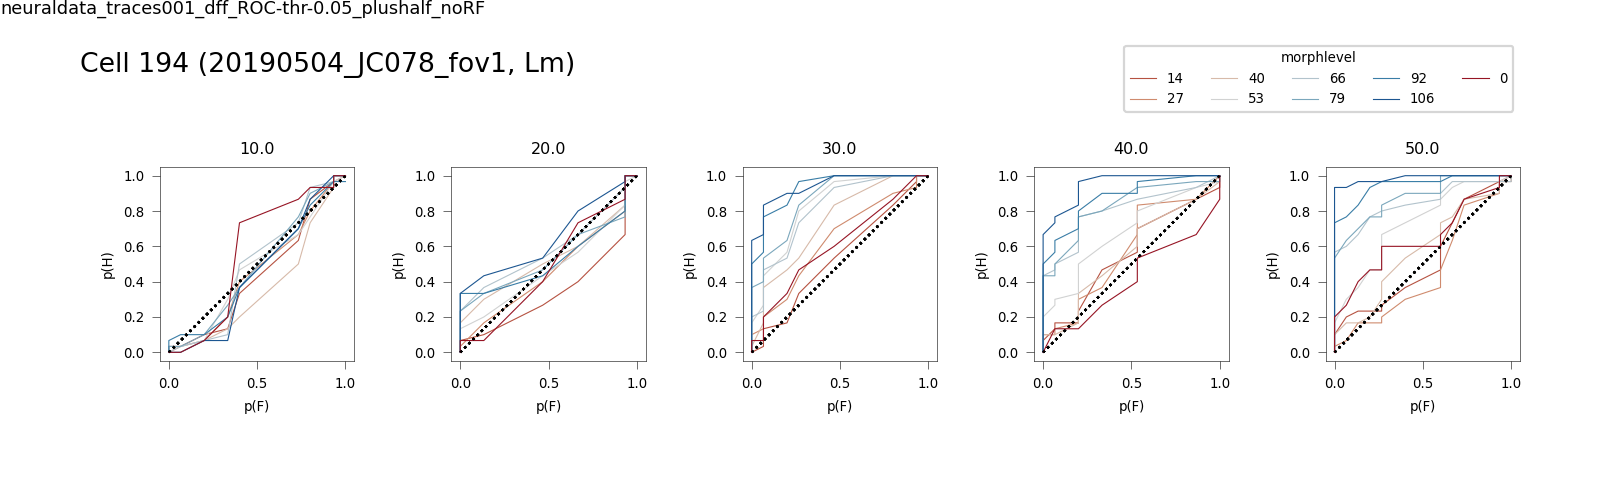

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/fit_gauss_selective__morphlevel examples Lm_20190504_JC078_fov1_rid194__auc


In [116]:
sizes = sorted(auc_['size'].unique())
cmap='plasma' if param=='morphstep' else 'RdBu'
lw=0.5

# Plot----
mdiffs = sorted(auc_[param].unique())
mdiff_colors = sns.color_palette('dark_%s' % colormap, n_colors=len(mdiffs))
#mdiff_colors = sns.color_palette(dark_cmap, n_colors=len(mdiffs))
colors = dict((k, v) for k, v in zip(mdiffs, mdiff_colors))

fig, axn = pl.subplots(1, len(sizes), figsize=(10,3))    
for mi, (sz, mp) in enumerate(resp_cfgs1):
    si = sizes.index(sz)
    ax=axn[si]
    if param=='morphstep':
        ax.plot(p_fas[mi, :], p_hits[mi, :], color=colors[mp], label=mp, lw=lw)
    else:
        ax.plot(p_fas[si, :], p_hits[mi, :], color=colors[mp], label=mp, lw=lw)
    ax.set_title(sz)
    ax.set_aspect('equal')
    ax.plot([0, 1], [0, 1], linestyle=':', color='k', lw=1)
    ax.set_xlabel('p(F)')
    ax.set_ylabel('p(H)')
ax.legend(bbox_to_anchor=(1, 1.25), loc='lower right', title=param, ncol=5)
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, hspace=0.5, wspace=0.5, top=0.7)
fig.text(0.05, 0.85, 'Cell %i (%s, %s)' % (rid, dk, va), fontsize=12)

pplot.label_figure(fig, data_id)
figname = '%s_%s_rid%i__auc' % (va, dk, rid)
pl.savefig(os.path.join(dst_dir, 'examples', '%s.svg' % figname))
print(dst_dir, 'examples', figname)

In [173]:
os.listdir(os.path.join(dst_dir, 'examples'))


['V1_20190507_JC083_fov1_rid8__auc.svg',
 'V1_20190507_JC083_fov1_rid8__fit.svg',
 'Lm_20190627_JC091_fov1_rid163__auc.svg',
 'Lm_20190627_JC091_fov1_rid163__fit.svg',
 'traces_Lm_20190627_JC091_fov1_cell163.svg',
 'traces_V1_20190507_JC083_fov1_cell008.svg',
 'traces_Lm_20190504_JC078_fov1_cell194.svg',
 'Lm_20190504_JC078_fov1_rid194__auc.svg']

In [174]:
opts = pneuro.default_options()
opts['widthalpha']=0.25
at_pc = 0.75 if opts['expType']=='2AFC' else 0.5
print(at_pc)

if Eff==0:
    opts['sigmoidName'] = 'neg_gauss'

0.75


In [175]:
opts

{'expType': '2AFC',
 'sigmoidName': 'gauss',
 'threshPC': 0.5,
 'widthalpha': 0.25}

<IPython.core.display.Javascript object>


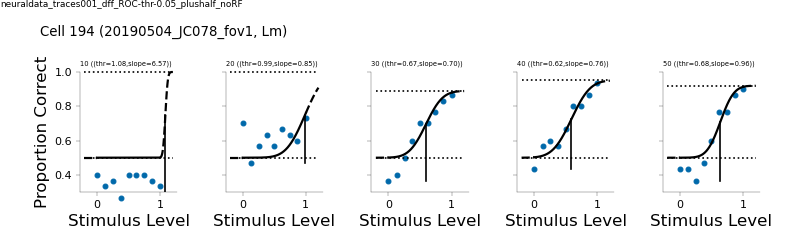

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:281: UserWarning: psignifit:borderWarning
The marginal for the width is not near 0 at the lower border.
This indicates that your data is not sufficient to exclude much lower widths.
Refer to the paper or the manual for more info on this topic.
  warnings.warn('psignifit:borderWarning\n'\
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:281: UserWarning: psignifit:borderWarning
The marginal for the width is not near 0 at the lower border.
This indicates that your data is not sufficient to exclude much lower widths.
Refer to the paper or the manual for more info on this topic.
  warnings.warn('psignifit:borderWarning\n'\
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:281: UserWarning: psignifit:borderWarning
The marginal for the width is not near 0 at the lower border.
This indicates that your data is not sufficient to 

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/fit_gauss_selective__morphlevel Lm_20190504_JC078_fov1_rid194__fit


In [176]:
normalize=param=='morphlevel'
fig, axn = pl.subplots(1, len(sizes), figsize=(10,3), sharex=True, sharey=True)    
jnd={}
sigma={}
new_r={}
for curr_sz, curr_auc in auc_.groupby(['size']):
    ai = sizes.index(curr_sz)
    data_ = pneuro.data_matrix_from_auc(curr_auc, param=param, normalize=normalize)
    res = ps.psignifit(data_, opts)
    new_r[curr_sz] = res
    ax=axn[ai]
    try:
        thr = ps.getThreshold(res, at_pc)[0] # Value at which function reaches at_pc correct
        slp = ps.getSlope(res, ps.getThreshold(res, at_pc)[0]) # Slope at given stimulus level
        info_str = '(thr=%.2f,slope=%.2f)' % (thr, slp)
        #print(info_str)
        [thr_0,CI0] = ps.getThreshold(res,0.25,1)
        [thr_1,CI1] = ps.getThreshold(res,0.75,1)
        jnd[curr_sz] = thr_1-thr_0
        #sparams = getStandardParameters.getStandardParameters(res,widthalpha=0.25)
        #sigma[curr_sz] = sparams[1]
    except Exception as e:
        print(e)
        info_str='n.f.'
        jnd[curr_sz] = None
        #sigma[curr_sz]=None
    ax = ps.psigniplot.plotPsych(res, axisHandle=ax, plotData=True, 
                                 lineColor='k', label=info_str, dataSize=5)
    ax.set_title('%i (%s)' % (curr_sz, info_str), loc='left', fontsize=fontsize)
    if ai>0:
        ax.set_ylabel('')
    ax.set_ylim([0.3, 1])
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, hspace=0.5, wspace=0.5, top=0.7)

fig.text(0.05, 0.85, 'Cell %i (%s, %s)' % (rid, dk, va), fontsize=12)

pplot.label_figure(fig, data_id)
figname = '%s_%s_rid%i__fit' % (va, dk, rid)
pl.savefig(os.path.join(dst_dir, 'examples', '%s.svg' % figname))
print(dst_dir, figname)

In [80]:
jnd

{10.0: -0.041001416954712794,
 20.0: -0.041215606680430034,
 30.0: None,
 40.0: -0.32411970894458786,
 50.0: -0.2654583632887066}

# Aggregate Neurometric Curves

In [30]:
def get_best_config_per_cell(auc):
    # Best config (size) for each cell
    max_auc_ixs = auc.groupby(['cell'])['AUC'].transform(max) == auc['AUC']
    ix = auc[max_auc_ixs]['cell'].drop_duplicates().index.tolist()
    best_sz_per_cell = [(r, c) for (r, c), g in auc.loc[ix].groupby(['cell', 'size'])]
    # assert len(pass_cells)==len(best_sz_per_cell)
    if len(best_sz_per_cell)==0:
        print("****[%s, %s] no cells." % (va, dk))
    best_auc = pd.concat([g for (r,c), g in \
                          auc.groupby(['cell', 'size']) if (r, c) in best_sz_per_cell])
    return best_auc

In [31]:
a_=[]
for (va, dk, ri), g in pSEL.groupby(['visual_area', 'datakey', 'cell']):
    best_a = get_best_config_per_cell(g)
    normal_eff = float(g['Eff'].unique())
    best_a['Eff'] = normal_eff
    a_.append(best_a)
best_aucs = pd.concat(a_)
best_aucs.head()

cell  level_1  index       AUC  morphlevel  size    Eff  n_trials  \
0   113        9      8  0.771111           0  20.0  106.0        30   
1   113       10      9  0.734444          14  20.0  106.0        30   
2   113       16     15  0.730000          92  20.0  106.0        30   
3   113       17     41  0.804444         106  20.0  106.0        30   
4   138       18     42  0.717778           0  30.0  106.0        30   

  visual_area              datakey object  
0          Li  20190315_JC070_fov1      A  
1          Li  20190315_JC070_fov1      A  
2          Li  20190315_JC070_fov1      B  
3          Li  20190315_JC070_fov1      B  
4          Li  20190315_JC070_fov1      A

In [32]:
best_aucs[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()

datakey  cell
visual_area               
Li               154   154
Lm               297   297
V1               536   536

In [33]:
max_level = 4 if param=='morphstep' else 1
min_level = 0

In [34]:
def interp_fit_values(fparams, fh, xmin=0, xmax=106, npoints=50):
    parnames = ['threshold', 'width', 'lambda', 'gamma','eta']
    fit, = fparams[parnames].values
    xv       = np.linspace(xmin, xmax, num=npoints)
    fv   = (1 - fit[2] - fit[3]) * fh(xv,     fit[0], fit[1]) + fit[3]
    df_ = pd.DataFrame({'x': xv, 'fitv': fv})
    return df_

In [35]:
roifits = roifits.drop_duplicates()

In [36]:
def aggregate_fit_curves(best_aucs, roifits, max_level=1, min_level=0, npoints=20):
    f_=[]
    for va, curr_aucs in best_aucs.groupby(['visual_area']):
        #curr_aucs = best_aucs[best_aucs.visual_area==va]
        for (dk, rid), r_auc in curr_aucs.groupby(['datakey', 'cell']):
            sz_ = float(r_auc['size'].unique())
            best_eff = float(r_auc['Eff'].unique())
            rfit = roifits[(roifits.visual_area==va) & (roifits.datakey==dk) 
                          & (roifits['cell']==rid) & (roifits['size']==sz_)].copy()
            if len(rfit)==0:
                continue
            if ( float(rfit['threshold'].values) > max_level)\
                            or ( float(rfit['threshold'].values) < min_level):
                continue
            opts = pneuro.default_options()
            opts['sigmoidName'] = 'neg_%s' % sigmoid \
                                    if (best_eff==0 and allow_negative) else sigmoid
            fh = getSig.getSigmoidHandle(opts)
            fitvs_ = interp_fit_values(rfit, fh, xmin=min_level, 
                                           xmax=max_level, npoints=npoints)
            if best_eff==0:
                # flip
                fitvs_['fitv'] = fitvs_['fitv'].values[::-1]
            fitvs_['datakey'] = dk
            fitvs_['cell'] = rid
            fitvs_['Eff'] = best_eff
            fitvs_['visual_area'] = va
            f_.append(fitvs_)
    fitvs = pd.concat(f_, axis=0)
    return fitvs

In [37]:
fitvs = aggregate_fit_curves(best_aucs, roifits, npoints=20,
                             max_level=max_level, min_level=min_level)

morph_means = aggregate_fit_curves(best_aucs, roifits, npoints=9,
                             max_level=max_level, min_level=min_level)
    

In [38]:
morphlevels

[0, 14, 27, 40, 53, 66, 79, 92, 106]

<IPython.core.display.Javascript object>


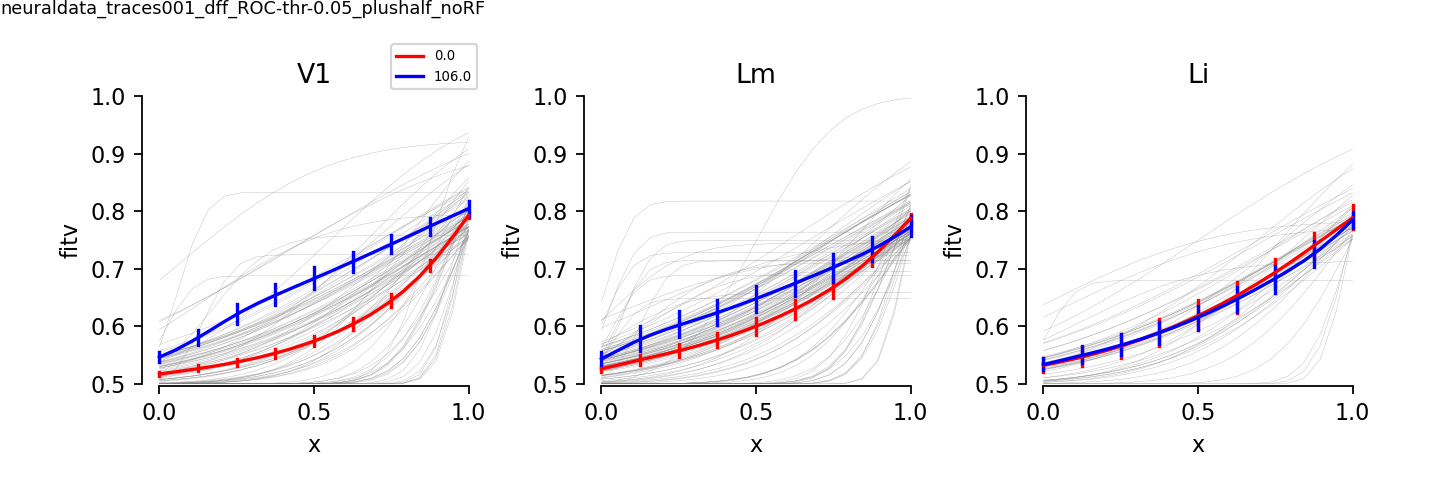

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/fit_gauss_selective__morphlevel aggregate_curves_hueAB


In [43]:
fig, axn = pl.subplots(1,3, figsize=(9,3))

for va, fvs in fitvs.groupby(['visual_area']):
    ai = visual_areas.index(va)
    ax=axn[ai]
    if va=='V1':
        fvs0 = fvs.copy()
        incl_ = [(dk, ri) for (dk, ri) in \
                 fvs[fvs['Eff']==0][['datakey', 'cell']]\
                 .drop_duplicates()[0::3].values]
        incl_2 = [(dk, ri) for (dk, ri) in \
                 fvs[fvs['Eff']==106][['datakey', 'cell']]\
                 .drop_duplicates()[0::3].values]
        incl_.extend(incl_2)
        fvs = pd.concat([g for (dk, ri), g in fvs0.groupby(['datakey', 'cell'])
                  if (dk, ri) in incl_])
    for (dk, ri), g in fvs.groupby(['datakey', 'cell']):
        ax.plot(g['x'], g['fitv'], lw=0.1, color='gray', zorder=-1)
    
for va, fvs in fitvs.groupby(['visual_area']):
    ai = visual_areas.index(va)
    ax=axn[ai]
    sns.lineplot(x='x', y='fitv', hue='Eff', ax=ax, data=fvs, 
                palette={0: 'r', 106:'b'}, err_style=None)
    means_ = morph_means[morph_means.visual_area==va].copy()
    sns.lineplot(x='x', y='fitv', hue='Eff', ax=ax, data=means_, 
                palette={0: 'r', 106:'b'}, err_style='bars', lw=0)
    ax.legend_.remove()
    ax.set_ylim([0.5, 1])
    ax.set_yticks(np.linspace(.5, 1, 6))
    ax.set_title(va)
    sns.despine(trim=True, offset=1, ax=ax)
pplot.crop_legend_labels(ax, n_hues=2, fontsize=6,
                         bbox_to_anchor=(1,1), loc='lower right')
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8, wspace=0.3)

pplot.label_figure(fig, data_id)
figname = 'aggregate_curves_hueAB'
pl.savefig(os.path.join(dst_dir, '%s_subsampled.svg' % figname))
print(dst_dir, figname)

In [63]:
roifits[(roifits['threshold']<1) \
        & (roifits['threshold']>0.)].groupby(['visual_area']).count()

threshold  width  lambda  gamma  eta  slope  thr  size  cell  \
visual_area                                                                 
Li                  66     66      66     66   66     62   62    66    66   
Lm                 145    145     145    145  145    125  125   145   145   
V1                 392    392     392    392  392    364  364   392   392   

             datakey  
visual_area           
Li                66  
Lm               145  
V1               392

In [ ]:
        print(va) #, dk)
        fig, ax = pl.subplots()
        for (va2, dk), g in best_aucs[best_aucs.visual_area==va]\
                    .groupby(['visual_area', 'datakey']):
            curr_fits, results = pneuro.load_fitparams(dk, roi_list=g['cell'].unique(),
                                         param=param, 
                                         allow_negative=True, 
                                        sigmoid=sigmoid, split_pupil=False,
                                         return_dicts=True, return_missing=False)
            if len(results)==0:
                print("... no fit: %s" % dk)
                continue
            for rid, res in results.items():
                sz_ = float(g[g['cell']==rid]['size'].unique())
                if (res[sz_]['Fit'][0] > max_level)\
                    or (res[sz_]['Fit'][0] < min_level):
                    #print('... %s skipping' % rid)
                    continue
                res_ = res[sz_]
                best_eff = float(g[g['cell']==rid]['Eff'].unique())
                if best_eff!=pref_eff:
                    continue

In [181]:
# from psignifit import getStandardParameters


In [ ]:
# AUC = pn2.aggregate_AUC(DATA,SDF, param=param, #midp=53,
#                         allow_negative=allow_negative, single_eff=single_eff,
#                         selective_only=False, selective_df=None,
#                         create_new=True)

In [64]:
roifits['threshold'].max()

1.2108132134316205

In [65]:
param

'morphlevel'

V1


<IPython.core.display.Javascript object>


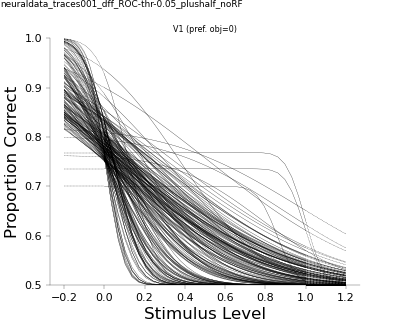

... no fit: 20190504_JC078_fov1
... no fit: 20190509_JC078_fov1
... no fit: 20190512_JC083_fov1
... no fit: 20190517_JC083_fov1
/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/fit_gauss_selective__morphlevel _V1_fits_pref0
Lm


<IPython.core.display.Javascript object>


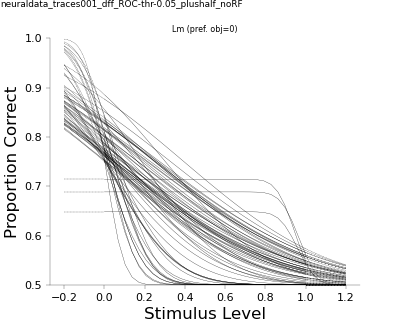

... no fit: 20190422_JC076_fov1
... no fit: 20191105_JC117_fov1
/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/fit_gauss_selective__morphlevel _Lm_fits_pref0
Li


<IPython.core.display.Javascript object>


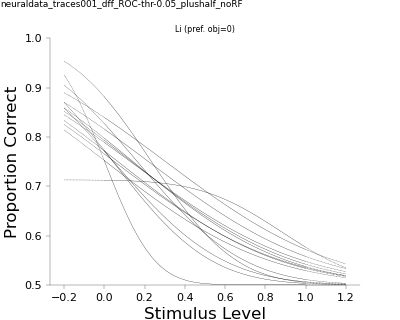

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/fit_gauss_selective__morphlevel _Li_fits_pref0
V1


<IPython.core.display.Javascript object>


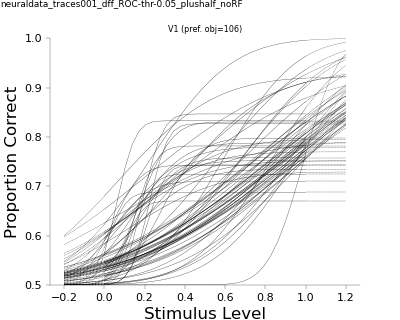

... no fit: 20190504_JC078_fov1
... no fit: 20190509_JC078_fov1
... no fit: 20190512_JC083_fov1
... no fit: 20190517_JC083_fov1
/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/fit_gauss_selective__morphlevel _V1_fits_pref106
Lm


<IPython.core.display.Javascript object>


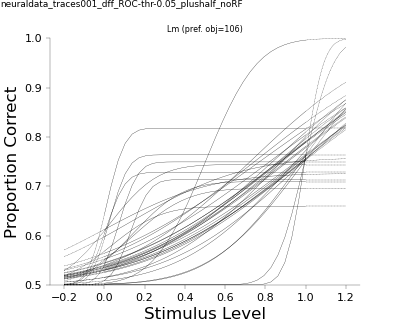

... no fit: 20190422_JC076_fov1
... no fit: 20191105_JC117_fov1
/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/fit_gauss_selective__morphlevel _Lm_fits_pref106
Li


<IPython.core.display.Javascript object>


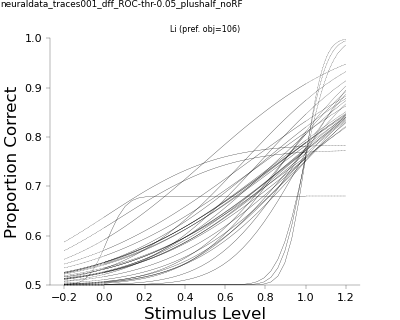

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/fit_gauss_selective__morphlevel _Li_fits_pref106


In [66]:
# va='Li'
min_level=0
max_level=1
pref_eff= 0
jnds_ = []

for pref_eff in [0, 106]:
    for va in visual_areas:
        print(va) #, dk)
        fig, ax = pl.subplots()
        for (va2, dk), g in best_aucs[best_aucs.visual_area==va]\
                    .groupby(['visual_area', 'datakey']):
            curr_fits, results = pneuro.load_fitparams(dk, roi_list=g['cell'].unique(),
                                         param=param, 
                                         allow_negative=True, 
                                        sigmoid=sigmoid, split_pupil=False,
                                         return_dicts=True, return_missing=False)
            if len(results)==0:
                print("... no fit: %s" % dk)
                continue
            for rid, res in results.items():
                sz_ = float(g[g['cell']==rid]['size'].unique())
                if (res[sz_]['Fit'][0] > max_level)\
                    or (res[sz_]['Fit'][0] < min_level):
                    #print('... %s skipping' % rid)
                    continue
                res_ = res[sz_]
                best_eff = float(g[g['cell']==rid]['Eff'].unique())
                if best_eff!=pref_eff:
                    continue
                thr=None; slp=None; jnd=None;
                ps.psigniplot.plotPsych(res_, axisHandle=ax, 
                                    plotThresh=False,
                                    plotData=False, lineWidth=0.25, plotAsymptote=False,
                                    thresh_height=0.525, npoints=30)
                try:
                    thr = ps.getThreshold(res_, at_pc)[0] # Value at which function reaches at_pc correct
                    slp = ps.getSlope(res_, ps.getThreshold(res_, at_pc)[0]) # Slope at given stimulus level
                    [thr_0,CI0] = ps.getThreshold(res_,0.25,1)
                    [thr_1,CI1] = ps.getThreshold(res_,0.75,1)
                    jnd = thr_1-thr_0
                except Exception as e:
                    pass
                df_ = pd.Series({'visual_area': va, 'datakey': dk, 'cell': rid, 
                            'slope': slp, 'threshold': thr, 'jnd': jnd, 
                            'Eff': pref_eff})
                jnds_.append(df_)
        ax.set_title('%s (pref. obj=%i)' % (va, pref_eff))
        pplot.label_figure(fig, data_id)
        figname = '_%s_fits_pref%i' % (va, pref_eff)
        pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
        print(dst_dir, figname)

In [67]:
best_eff

106.0

In [68]:
jnds = pd.concat(jnds_, axis=1).T

In [70]:
jnd_params = ['slope', 'threshold', 'jnd']
jnds[jnd_params] = jnds[jnd_params].astype(float) #()
jnds.groupby(['visual_area', 'datakey', 'Eff']).mean()

slope  threshold       jnd
visual_area datakey             Eff                               
Li          20190315_JC070_fov1 106  0.758523   0.878031  0.574542
            20190322_JC073_fov1 106  0.450848   0.979619  0.596835
            20190422_JC076_fov1 0   -0.309565   0.049734 -0.869211
                                106  0.319178   0.936744  0.844450
            20190602_JC091_fov1 0   -0.593909   0.089788 -0.523971
                                106  0.626196   0.871982  0.604392
            20190606_JC091_fov1 0         NaN        NaN       NaN
                                106  0.219540   0.742343  0.727123
            20190607_JC091_fov1 0   -0.336331   0.142269 -0.800053
                                106  0.326018   0.932378  0.825360
            20190609_JC099_fov1 0   -0.302717   0.216860 -0.888944
                                106  0.323740   0.911556  0.833938
            20190614_JC091_fov1 0   -0.393964   0.090334 -0.708799
            20190617_JC099_fov1 0   -0.313760   0.143354 -0.858053
            20191111_JC120_fov1 106  0.313052   0.861981  0.861630
Lm          20190430_JC078_fov1 0   -0.492660   0.105178 -0.629529
                                106  0.409539   0.893026  0.662845
            20190504_JC078_fov1 0   -0.345401   0.102579 -0.779043
                                106  0.647025   0.687996  0.575261
            20190506_JC080_fov1 0   -0.316271   0.124517 -0.852118
                                106  0.281996   0.940288  0.781212
            20190508_JC083_fov1 0   -0.411399   0.136950 -0.728075
                                106  0.643308   0.634746  0.585199
            20190509_JC078_fov1 0   -0.303808   0.138635 -0.885797
                                106       NaN        NaN       NaN
            20190512_JC083_fov1 0   -0.335574   0.073651 -0.808840
                                106  0.391608   0.887044  0.723114
            20190513_JC078_fov1 0   -0.329849   0.086844 -0.818423
                                106  0.319036   0.980426  0.843423
            20190517_JC083_fov1 0   -0.429220   0.143691 -0.668277
                                106  0.803909   0.958150  0.601093
            20190525_JC084_fov1 0   -1.262943   0.055545 -0.287670
                                106       NaN        NaN       NaN
            20190603_JC080_fov1 0   -0.335937   0.143556 -0.801926
                                106  0.669931   0.781918  0.584488
            20190618_JC097_fov1 0   -0.341314   0.067429 -0.788372
            20190627_JC091_fov1 0   -0.407457   0.234493 -0.689238
                                106       NaN        NaN       NaN
V1          20190501_JC076_fov1 0   -0.476992   0.099974 -0.608272
                                106  0.307936   0.835138  0.873826
            20190507_JC083_fov1 0   -0.566415   0.158220 -0.582256
                                106  0.439622   0.675452  0.629788
            20190508_JC083_fov1 0   -0.440139   0.178076 -0.665961
            20190510_JC083_fov1 0   -0.438879   0.140061 -0.630795
                                106  0.501496   0.777194  0.600457
            20190511_JC083_fov1 0   -0.412344   0.119997 -0.642448
                                106  0.454805   0.632401  0.529825
            20190522_JC084_fov1 0   -0.571685   0.112158 -0.622913
                                106  0.508277   0.761252  0.683982
            20190613_JC097_fov1 0   -1.335178   0.049354 -0.341152
            20190616_JC097_fov1 0   -0.878351   0.089452 -0.545446
                                106  0.307825   0.814022  0.602497
            20190617_JC097_fov1 0   -0.659438   0.112734 -0.535253
                                106  0.328512   0.964580  0.819095
            20190622_JC085_fov1 0   -0.778396   0.069533 -0.439682
                                106  0.443403   0.551190  0.475180
            20191006_JC110_fov1 0   -0.366744   0.089382 -0.736866
                                106  0.300017   0.801032  0.769289

In [84]:
jnds['abs_jnd'] = jnds['jnd'].abs()
jnds['abs_slope'] = jnds['slope'].abs()
jnds['abs_threshold'] = None
for e, ef in jnds.groupby(['Eff']):
    if e==0:
        jnds.loc[ef.index, 'abs_threshold'] = 1-ef['threshold'].values
    else:
        jnds.loc[ef.index, 'abs_threshold'] = ef['threshold'].values

<IPython.core.display.Javascript object>


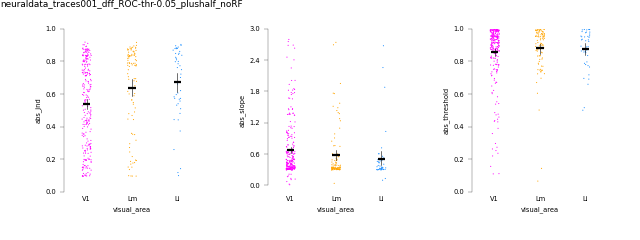

In [120]:
object_colors= {0: 'r', 106: 'b'}
fig, axn = pl.subplots(1,3, figsize=(8,3))
for ax, metric in zip(axn.flat, ['abs_jnd', 'abs_slope', 'abs_threshold']):
    sns.stripplot(x='visual_area', y=metric, data=jnds,
                 ax=ax, hue='visual_area', order=visual_areas, palette=area_colors,
                 zorder=-1, s=1)
    sns.pointplot(x='visual_area', y=metric, data=jnds, ci=95,
                 ax=ax, join=False, zorder=-1, s=1, color='k', markers='_',
                 errwidth=0.5, lw=0.5)
    if metric in ['abs_jnd', 'abs_threshold']:
        ax.set_ylim([0, 1])
        ax.set_yticks(np.linspace(0, 1, 6))
    else:
        ax.set_yticks(np.linspace(0, 3, 6))
    ax.legend_.remove()
    sns.despine(bottom=True, trim=True)
    ax.tick_params(which='both', axis='x', size=0)
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.5, hspace=0.5, bottom=0.2)

pplot.label_figure(fig, data_id)
figname = '_JNDs' 
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

<IPython.core.display.Javascript object>


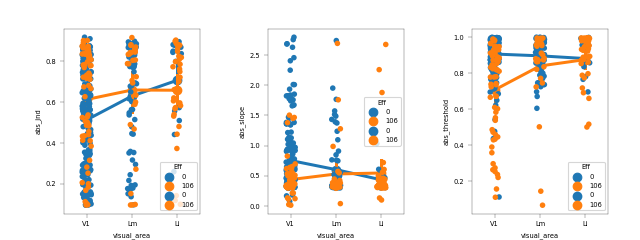

In [91]:
object_colors= {0: 'r', 106: 'b'}
fig, axn = pl.subplots(1,3, figsize=(8,3))
for ax, metric in zip(axn.flat, ['abs_jnd', 'abs_slope', 'abs_threshold']):
    sns.stripplot(x='visual_area', y=metric, data=jnds,
                 ax=ax, hue='Eff')
    sns.pointplot(x='visual_area', y=metric, data=jnds,
                 ax=ax, hue="Eff")
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.5, hspace=0.5)

In [52]:
print(selective_df[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())
print(roifits[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())


             datakey  cell
visual_area               
Li               387   387
Lm               717   717
V1               979   979
             datakey  cell
visual_area               
Li               135   135
Lm               310   310
V1               527   527


In [163]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/fit_gauss_selective__morphstep'

In [162]:
psign_pars = ['threshold', 'width', 'lambda', 'gamma','eta']
parnames = copy.copy(psign_pars)
parnames.extend(['thr', 'slope'])
parnames

['threshold', 'width', 'lambda', 'gamma', 'eta', 'thr', 'slope']

In [166]:
# roifits = fitdf.copy()

In [308]:
roifits.shape, roifits.dropna().shape

((5125, 12), (5041, 12))

In [309]:
onefit = pd.concat([g for (va, dk, ci), g in roifits.dropna().drop_duplicates()\
                    .groupby(['visual_area', 'datakey', 'cell']) \
                        if len(g['Eff'].unique())==1])

print(onefit[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())
for p in parnames:
    if p not in onefit.columns:
        print(p)
        continue
    onefit[p] = onefit[p].astype(float)

             datakey  cell
visual_area               
Li                52    52
Lm                70    70
V1               152   152


In [310]:
onefit['Eff'].unique()

array([106, 0], dtype=object)

In [311]:
for p in parnames:
    if p not in roifits.columns:
        continue
    roifits[p] = roifits[p].astype(float)

In [312]:
rfits = onefit.copy() #onefit.copy()
# passfits = rfits[(rfits['threshold']>=0) & (rfits['threshold']<=106)
#                   & (rfits['lambda']>0) & (rfits['width']<=106*1.5)]
meanfits = rfits.groupby(['visual_area', 'datakey', 'cell', 'Eff']).mean().reset_index()
meanfits.head()

print(meanfits[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())


             datakey  cell
visual_area               
Li                52    52
Lm                70    70
V1               152   152


In [319]:
rfits['threshold'].min(), rfits['threshold'].max()

(-0.8214979889267489, 5.074803122452527)

In [59]:
max_level = 4 if param=='morphstep' else 1
min_level = 0

In [184]:
meanfits_filt = meanfits[(meanfits['threshold']>=0) & (rfits['threshold']<=max_level)]
#                   & (meanfits['lambda']>0) & (meanfits['width']<=1.5)]

# meanfits_filt = meanfits[(meanfits['lambda']>0.0005) & (meanfits['eta']>0.0005)].copy()
print(meanfits_filt[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())


             datakey  cell
visual_area               
Li                 1     1
V1                 2     2


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


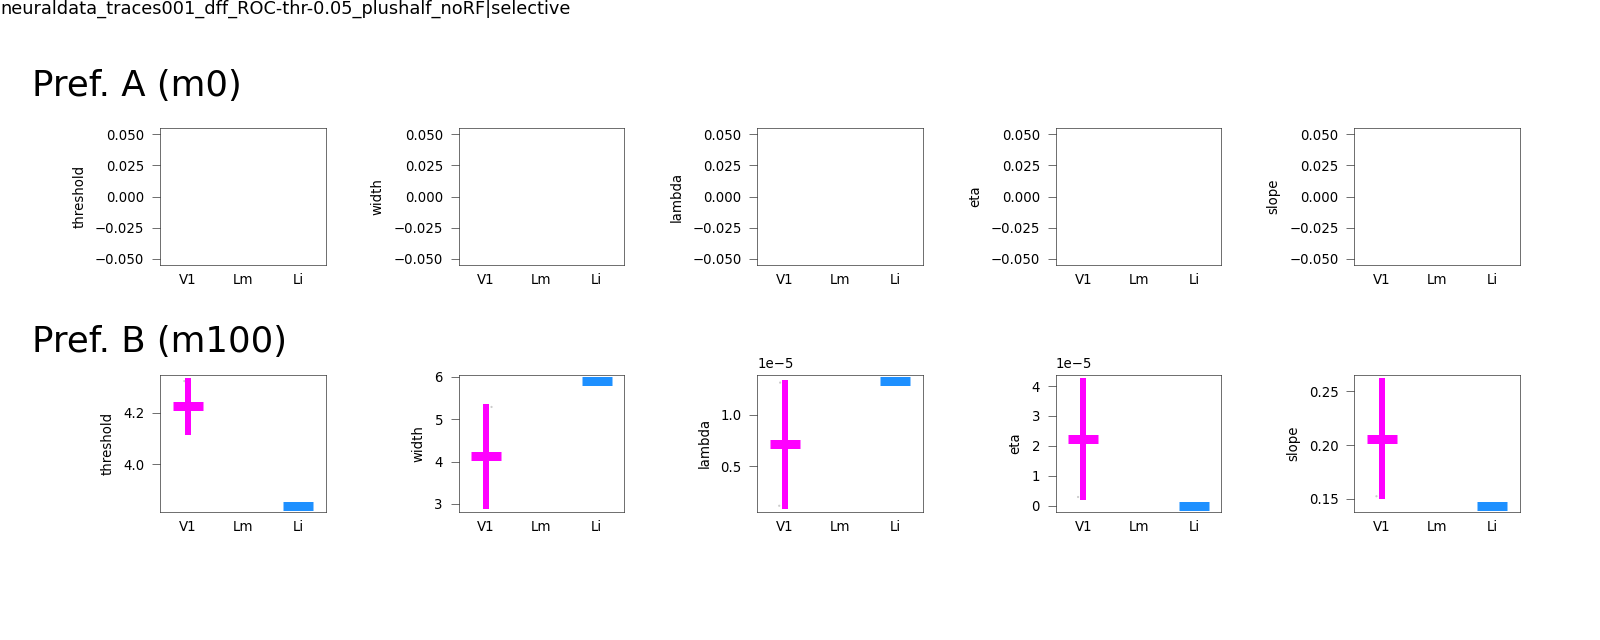

PARAM: threshold -----------------------------------------
                 count   mean    std    min    25%    50%    75%    max
visual_area Eff                                                        
Li          106    1.0  3.839    NaN  3.839  3.839  3.839  3.839  3.839
V1          106    2.0  4.224  0.139  4.126  4.175  4.224  4.273  4.323
PARAM: width -----------------------------------------
                 count   mean    std    min    25%    50%    75%    max
visual_area Eff                                                        
Li          106    1.0  3.839    NaN  3.839  3.839  3.839  3.839  3.839
V1          106    2.0  4.224  0.139  4.126  4.175  4.224  4.273  4.323
PARAM: lambda -----------------------------------------
                 count   mean    std    min    25%    50%    75%    max
visual_area Eff                                                        
Li          106    1.0  3.839    NaN  3.839  3.839  3.839  3.839  3.839
V1          106    2.0  4.224  0.139  

In [185]:
filter_params=True
filter_str = 'validparams' if filter_params else ''

plotf = meanfits_filt.copy() if filter_params else meanfits.copy()

plot_params = ['threshold', 'width', 'lambda', 'eta','slope']

fig, axn = pl.subplots(2, len(plot_params), figsize=(len(plot_params)*2, 4))
for pi, p in enumerate(plot_params):
    ax=axn[0, pi]
    print("PARAM: %s -----------------------------------------" % p)
    print(plotf.groupby(['visual_area', 'Eff'])['threshold'].describe().round(3))
    
    sns.stripplot(y=p, data=plotf[plotf['Eff']==0], x='visual_area', ax=ax,
                 order=visual_areas, color='k', alpha=0.2, size=1, zorder=-1)
    sns.pointplot(y=p, data=plotf[plotf['Eff']==0], x='visual_area', ax=ax,
                 order=visual_areas, palette=area_colors, markers='_', scale=2, zorder=1)
    
    ax=axn[1, pi]
    sns.stripplot(y=p, data=plotf[plotf['Eff']==106], x='visual_area', ax=ax,
                 order=visual_areas, color='k', alpha=0.2, size=1, zorder=-1)
    sns.pointplot(y=p, data=plotf[plotf['Eff']==106], x='visual_area', ax=ax,
                 order=visual_areas, palette=area_colors, markers='_', scale=2, zorder=1)
    
for ax in axn.flat:
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')

fig.text(0.02, 0.85, 'Pref. A (m0)', fontsize=16)
fig.text(0.02, 0.45, 'Pref. B (m100)', fontsize=16)

pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8, wspace=0.8, hspace=0.8)

p3.label_figure(fig, '%s|%s' % (data_id, selective_str))

figname = 'fitparams_%s-crit-%.2f_meansbycell_%s' % (selective_str, criterion, filter_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


<IPython.core.display.Javascript object>


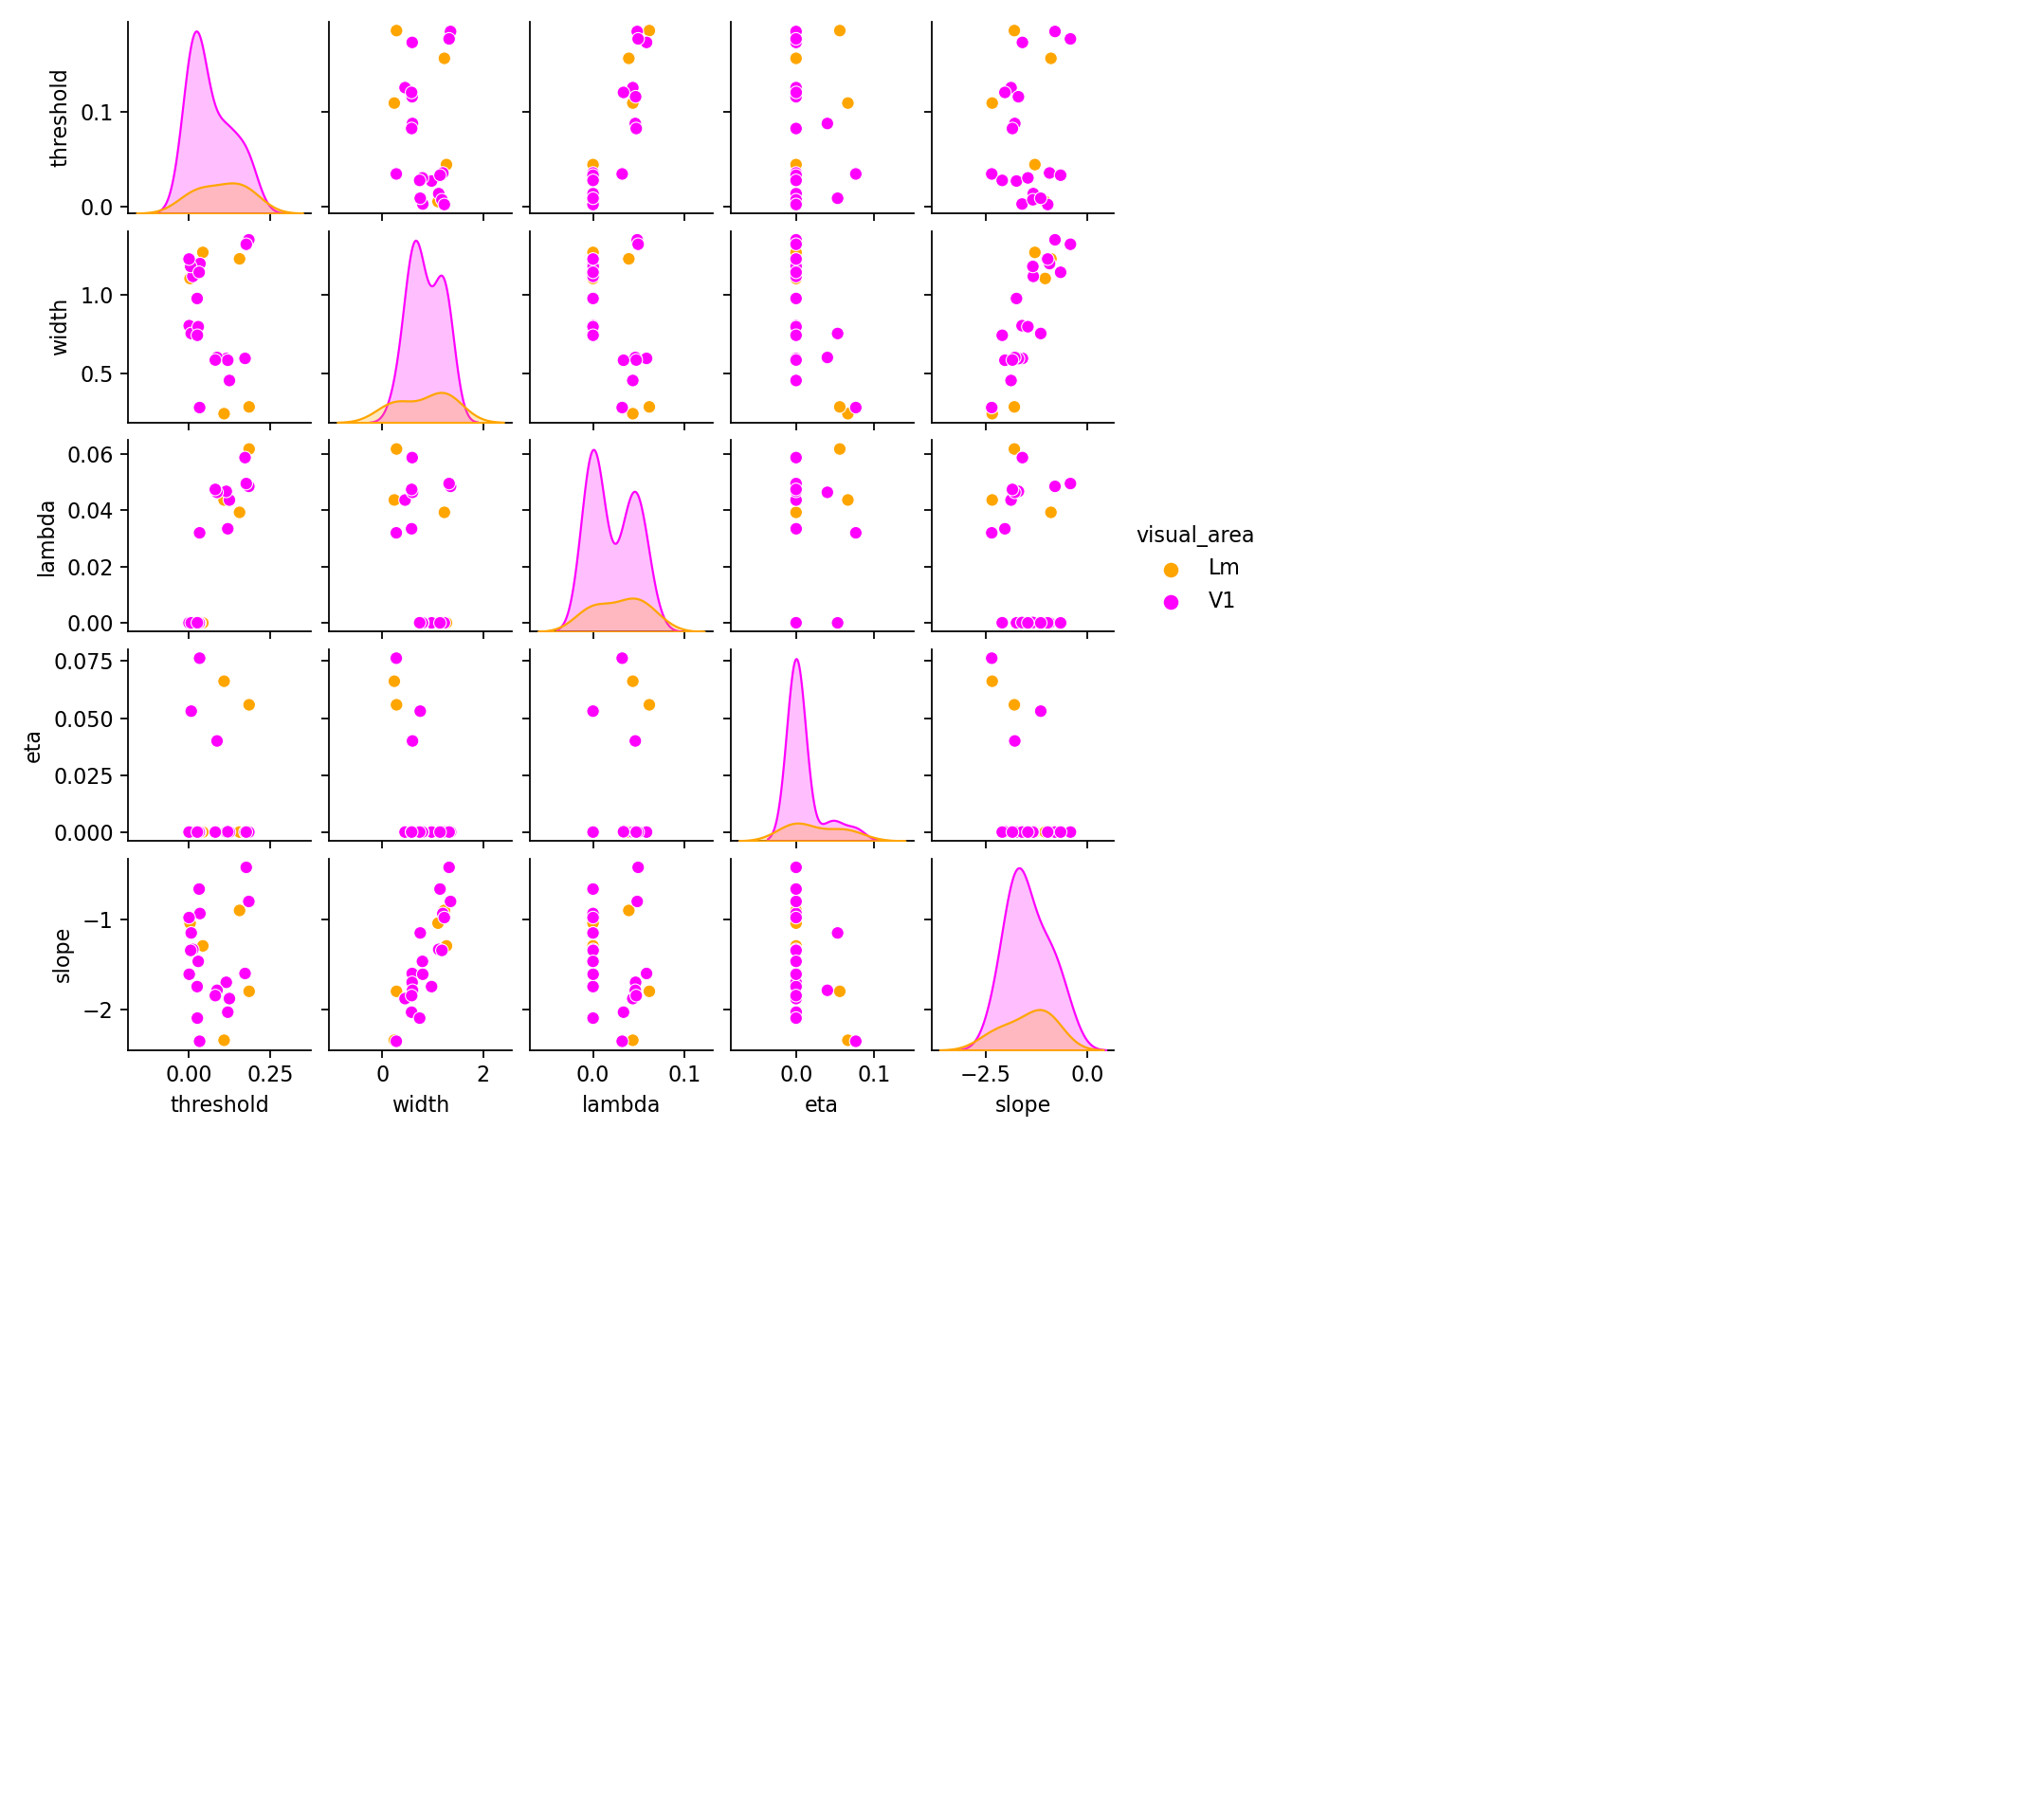

In [85]:


sns.pairplot(plotf[plotf['Eff']==0], hue='visual_area', vars=plot_params, height=1.5,
            palette=area_colors)

In [86]:
filter_params=False
filter_str = 'validparams' if filter_params else ''

plotf = meanfits_filt.copy() if filter_params else meanfits.copy()


plot_params = ['threshold', 'width', 'lambda', 'eta','slope']

fig, axn = pl.subplots(1, len(plot_params), figsize=(len(plot_params)*2, 4))
for pi, p in enumerate(plot_params):
    ax=axn[pi]
    print("PARAM: %s -----------------------------------------" % p)
    print(plotf.groupby(['visual_area'])[p].describe().round(3))
    
    sns.stripplot(y=p, data=plotf, x='visual_area', ax=ax,
                 order=visual_areas, color='k', alpha=0.2, size=1, zorder=-1)
    sns.pointplot(y=p, data=plotf, x='visual_area', ax=ax,
                 order=visual_areas, palette=area_colors, markers='_', scale=2, zorder=1)
    
# ax.tick_params(which='both', axis='x', size=0)
# ax.set_xlabel('')

# fig.text(0.02, 0.85, 'Pref. A (m0)', fontsize=16)
# fig.text(0.02, 0.45, 'Pref. B (m100)', fontsize=16)

pl.subplots_adjust(left=0.1, right=0.95, bottom=0.3, top=0.8, wspace=0.8, hspace=0.8)

p3.label_figure(fig, '%s|%s' % (data_id, selective_str))

figname = 'fitparams_combineAB_%s-crit-%.2f_meansbycell_%s' % (selective_str, criterion, filter_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


<IPython.core.display.Javascript object>

PARAM: threshold -----------------------------------------
             count   mean    std    min    25%    50%    75%    max
visual_area                                                        
Li           135.0  0.585  0.577 -0.143 -0.089  0.996  1.096  1.161
Lm           310.0  0.485  0.585 -0.152 -0.084  0.025  1.107  1.172
V1           527.0  0.278  0.517 -0.168 -0.085 -0.056  0.911  1.162
PARAM: width -----------------------------------------
             count   mean    std    min    25%    50%    75%    max
visual_area                                                        
Li           135.0  0.732  0.252  0.241  0.536  0.748  0.900  1.368
Lm           310.0  0.682  0.284  0.239  0.488  0.655  0.874  1.523
V1           527.0  0.718  0.295  0.240  0.523  0.687  0.907  1.657
PARAM: lambda -----------------------------------------
             count   mean    std  min  25%  50%  75%    max
visual_area                                                
Li           135.0  0.002  0.0

# Plot neurometric curves

In [314]:
print(allow_negative)
allow_negative=False
sig='gauss'
opts = pneuro.default_options()
opts['sigmoidHandle'] = getSig.getSigmoidHandle(opts)
opts['widthalpha'] = .05
max_level = 4 if param=='morphstep' else 1
f_=[]
for (va, dk, ci, sz), g in onefit.groupby(['visual_area', 'datakey', 'cell', 'size']):
    eff = int(g['Eff'].unique())
    opts['sigmoidName'] = 'neg_%s' % sigmoid if (eff==0 and allow_negative) else sig
    fh = getSig.getSigmoidHandle(opts)
    fvs = pneuro.get_fit_values(g, fh, xmin=0, xmax=max_level, npoints=50)
    f_.append(fvs)
fitvs = pd.concat(f_)

False


In [315]:
fitvs['x'].max()

4.0

In [316]:
onefit['threshold'].max(), onefit['threshold'].min()

(5.074803122452527, -0.8214979889267489)

In [200]:
def plot_thres_mean_sem(fpars, ax, thresh_height=0.55, ymin=0.5, lw=1, ls='-',
                       grouper=['Eff'], group_colors={0: 'r', 1: 'b'}, fill_alpha=0.2, ci='sem'):
    
    #ax.set_ylim([ax.get_ylim()[0], 1])

    mean_thr = fpars.groupby(grouper)['threshold'].mean()
    if ci=='ci':
        sem_thr = fpars.groupby(grouper)['threshold'].apply(pplot.get_empirical_ci)
    else:
        sem_thr = fpars.groupby(grouper)['threshold'].sem()
    
    grp_ = fpars[grouper].unique()
    for i in grp_:
        print(i, group_colors[i])

    for eff, ecol in group_colors.items():
        thr_ = mean_thr.loc[eff]
        sd_ = sem_thr.loc[eff]
        #print(a_, s_, thr_hi, sd_hi)
        
        x0 = (sd_[0], ymin) if ci=='ci' else (thr_-sd_, ymin) # point of origin.
        bar_width = sd_[1]-sd_[0] if ci=='ci' else sd_*2.
        ax.plot([thr_, thr_], [ymin, thresh_height], color=ecol, lw=lw, linestyle=ls)
        ax.add_patch(patches.Rectangle(xy=x0, width=bar_width,
                    height=thresh_height-ymin, linewidth=0, color=ecol, fill=True, alpha=fill_alpha) )

<IPython.core.display.Javascript object>


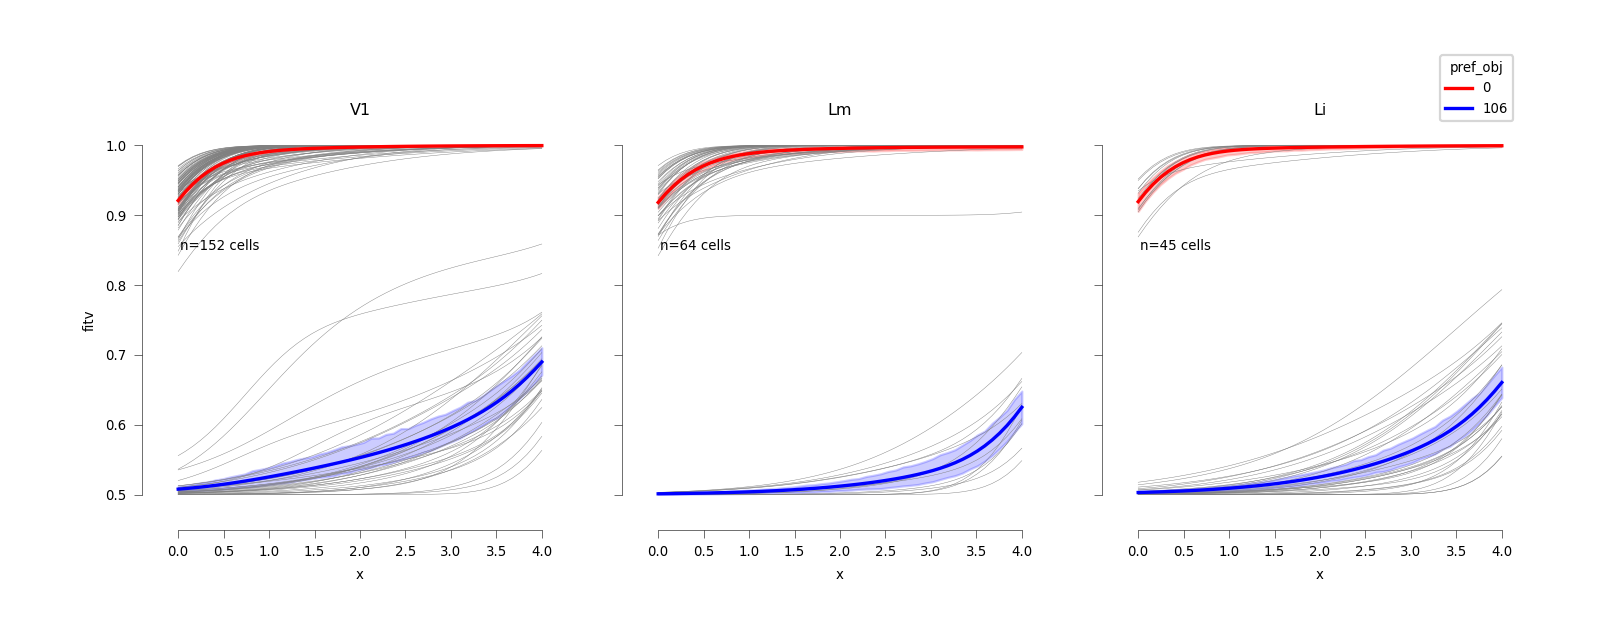

In [201]:
plot_each_cell=True

plot_str = 'ploteach' if plot_each_cell else ''

object_colors={0: 'r', 106: 'b'}

mean_fpars_by_cell = onefit.groupby(['visual_area', 'datakey', 'cell', 'Eff']).mean().reset_index()
mean_fitvs_by_cell = fitvs.groupby(['visual_area', 'datakey', 'cell', 'Eff', 'x']).mean().reset_index()

fig, axn = pl.subplots(1,3, figsize=(10,4), sharex=True, sharey=True)
for va, fv in mean_fitvs_by_cell.groupby(['visual_area']):
    ai = visual_areas.index(va)
    ax = axn[ai]
    
    if plot_each_cell:
        for (dk, c, eff), gg in fv.groupby(['datakey', 'cell', 'Eff']):
            ax.plot(gg['x'], gg['fitv'], color='gray', lw=0.2)

    sns.lineplot(x='x', y='fitv', hue='Eff', data=fv, ax=ax, palette=object_colors)
    ax.set_title(va)
    
    fpars = mean_fpars_by_cell[(mean_fpars_by_cell.visual_area==va)].copy()
    
    thresh_height=0.48 if plot_each_cell else 0.505 
    ymin=0.47 if plot_each_cell else 0.5 
    text_loc = 0.85 if plot_each_cell else 0.65
#     plot_thres_mean_sem(fpars, ax, thresh_height=thresh_height, ymin=ymin, lw=1, ls='-',
#                        grouper='Eff', group_colors=object_colors, fill_alpha=0.2, ci='ci')
        
    ax.legend_.remove()
    ncells = fpars.shape[0]
    ax.text(0.02, text_loc, 'n=%i cells' % ncells, fontsize=6)
    
sns.despine(trim=True, offset=8)    
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8)
axn[-1].legend(bbox_to_anchor=(1,1), loc='lower right', title='pref_obj')

#pplot.label_figure(fig, '%s|%s' % (data_id, selective_str))

# figname = 'avg_all_roi_curves_by_area_%s__%s' % (plot_str,filter_str)
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
# print(dst_dir, figname)


In [209]:
dk = '20190602_JC091_fov1'
va='Li'
g = best_aucs[(best_aucs.visual_area==va) & (best_aucs.datakey==dk)]

In [229]:
curr_dst_dir

'/n/coxfs01/2p-data/JC083/20190507/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_8afe5f_traces001_7ab5af_traces001_488b31_traces001_c8dfc7_traces001_df5b92_traces001_431894/neurometric/fits/gauss'

In [213]:
#print(va, dk)
curr_fits, results = pneuro.load_fitparams(dk, roi_list=g['cell'].unique(),
                                 param=param, 
                                 allow_negative=allow_negative, 
                                sigmoid=sigmoid, split_pupil=False,
                                 return_dicts=True, return_missing=False)

Missing 17 cells


In [216]:
results.keys()

dict_keys([13, 18, 34, 37, 38, 39, 40, 41, 42, 43, 44, 47, 50, 51, 52, 53, 57, 62, 71, 73, 74, 75, 76, 77, 81])

In [221]:
res[10].keys()

dict_keys(['X1D', 'marginals', 'marginalsX', 'marginalsW', 'Posterior', 'logPmax', 'weight', 'integral', 'Fit', 'options', 'data', 'conf_Intervals', 'timestamp'])

<IPython.core.display.Javascript object>


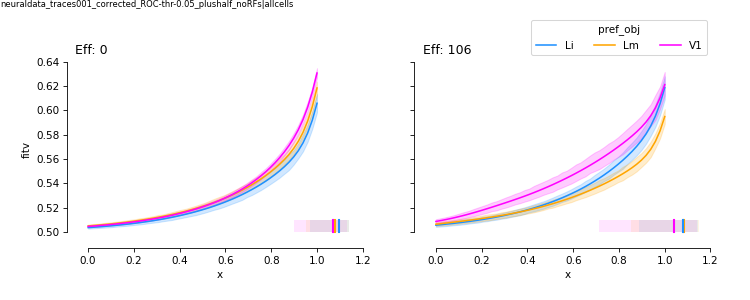

Li dodgerblue
Lm orange
V1 magenta
Li dodgerblue
Lm orange
V1 magenta
/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/fit_gauss_reverse average_area_curves_splitEff_


In [132]:

fig, axn = pl.subplots(1,2, figsize=(10,4), sharex=True, sharey=True)
for ai, (eff, fv) in enumerate(mean_fitvs_by_cell.groupby(['Eff'])):
    ax = axn[ai]
    
    sns.lineplot(x='x', y='fitv', hue='visual_area', data=fv, ax=ax, palette=area_colors)
    ax.set_title('Eff: %i' % eff, loc='left')
    
    fpars = mean_fpars_by_cell[(mean_fpars_by_cell['Eff']==eff)].copy()
    plot_thres_mean_sem(fpars, ax, thresh_height=0.51, ymin=0.5, lw=2, ls='-',
                       grouper='visual_area', group_colors=area_colors, fill_alpha=0.1, ci='ci')

    ax.legend_.remove()

sns.despine(trim=True, offset=8)    
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8)
axn[-1].legend(bbox_to_anchor=(1,1), loc='lower right', title='pref_obj', ncol=3)

p3.label_figure(fig, '%s|%s' % (data_id, selective_str))

figname = 'average_area_curves_splitEff_%s' % filter_str
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

<IPython.core.display.Javascript object>


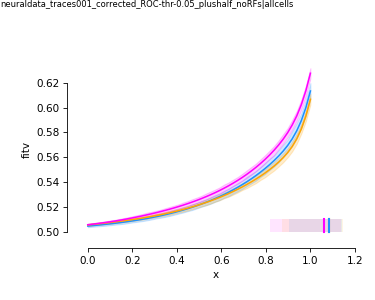

Li dodgerblue
Lm orange
V1 magenta
/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/fit_gauss_reverse average_area_curves_combined_


In [134]:

fig, ax = pl.subplots(figsize=(5,4), sharex=True, sharey=True)

sns.lineplot(x='x', y='fitv', hue='visual_area', data=mean_fitvs_by_cell, ax=ax, palette=area_colors)


fpars = mean_fpars_by_cell.copy()
plot_thres_mean_sem(fpars, ax, thresh_height=0.51, ymin=0.5, lw=2, ls='-',
                   grouper='visual_area', group_colors=area_colors, fill_alpha=0.1, ci='ci')

ax.legend_.remove()

sns.despine(trim=True, offset=8)    
pl.subplots_adjust(left=0.2, right=0.95, bottom=0.2, top=0.8)
axn[-1].legend(bbox_to_anchor=(1,1), loc='lower right', title='pref_obj', ncol=3)

p3.label_figure(fig, '%s|%s' % (data_id, selective_str))

figname = 'average_area_curves_combined_%s' % filter_str
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [516]:
va='V1'
dk = '20191006_JC110_fov1'
roifit[(roifit['visual_area']==va) & (rfit.datakey==dk)]['cell'].unique()


NameError: name 'roifit' is not defined

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/seaborn/distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)


<IPython.core.display.Javascript object>


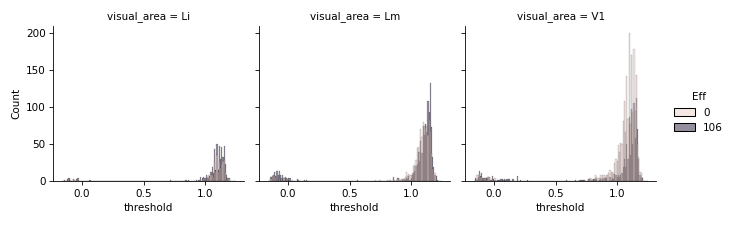

In [69]:
sns.displot(x='threshold', hue='Eff', data=onefit, col='visual_area', ax=ax, height=3)


In [317]:

def group_fit_vals(g, opts=None, allow_negative=True, xmin=0, xmax=1):
    eff = int(g['Eff'].unique())
    if opts is None:
        opts = p3.default_options()
    opts['sigmoidName'] = 'neg_%s' % sig if (eff==0 and allow_negative) else sig
    fh = getSig.getSigmoidHandle(opts)
    fvs = p3.get_fit_values(g, fh, xmin=xmin, xmax=xmax, npoints=50)
    
    return fvs

def plot_roi_fit(fparams, grouper='size', ax=None, 
                 plot_threshold=True, ymin=0.5, yheight=0.1, col='k',
                cmap='cubehelix'):
    if ax is None:
        fig, ax = pl.subplots()
        
    if grouper is not None:
        curr_fvs = fparams.groupby(grouper).apply(group_fit_vals)
        vals = sorted(fparams[grouper].unique())
        cols = sns.color_palette(cmap, n_colors=len(vals))
        group_colors = dict((v, c) for v, c in zip(vals, cols))
    else:
        curr_fvs = group_fit_vals(fparams)
        col='k'
        group_colors=None
        
    sns.lineplot(x='x', y='fitv', hue=grouper, data=curr_fvs, ax=ax, palette=group_colors)
    
    if plot_threshold:
        if grouper is not None:
            for v, g in fparams.groupby(grouper):
                thr = float(g['threshold'].values)
                ax.plot([thr, thr], [ymin, ymin+yheight], color=group_colors[v])
        else:
            thr = float(fparams['threshold'].values)
            ax.plot([thr, thr], [ymin, ymin+yheight], color=col)
    
    #)
    sns.despine(offset=8, trim=True)
    
    return ax

In [325]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit'

In [326]:
curr_dst_dir = os.path.join(dst_dir, 'examples')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)

In [323]:
va='V1'
dk = '20191006_JC110_fov1'
rfits = roifits[(roifits.visual_area==va) & (roifits.datakey==dk)].copy()
print(rfits.shape)

rid=240
fparams = rfits[rfits['cell']==rid]
fparams

(155, 12)


threshold     width        lambda  gamma           eta     slope  \
6880   1.133696  1.170004  2.624277e-09    0.5  2.799685e-07  0.560854   
6881   1.098474  1.194989  5.882353e-09    0.5  3.888809e-08  0.549128   
6882   0.899865  2.074527  3.512068e-05    0.5  1.218568e-08  0.316292   
6883   0.859538  1.883427  2.751141e-09    0.5  1.561955e-08  0.348408   
6884   1.074169  0.242425  1.574938e-07    0.5  2.543757e-04  2.706828   

           thr visual_area              datakey  cell  size  Eff  
6880  1.133696          V1  20191006_JC110_fov1   240  10.0  106  
6881  1.098474          V1  20191006_JC110_fov1   240  20.0  106  
6882  0.899920          V1  20191006_JC110_fov1   240  30.0  106  
6883  0.859538          V1  20191006_JC110_fov1   240  40.0  106  
6884  1.074169          V1  20191006_JC110_fov1   240  50.0  106

In [324]:
opts = p3.default_options()
curr_fvs = fparams.groupby(['size']).apply(group_fit_vals, opts=opts)
curr_fvs.head()

x      fitv visual_area              datakey  cell  size  Eff
size                                                                        
10.0 0  0.000000  0.500359          V1  20191006_JC110_fov1   240  10.0  106
     1  0.020408  0.500437          V1  20191006_JC110_fov1   240  10.0  106
     2  0.040816  0.500530          V1  20191006_JC110_fov1   240  10.0  106
     3  0.061224  0.500641          V1  20191006_JC110_fov1   240  10.0  106
     4  0.081633  0.500774          V1  20191006_JC110_fov1   240  10.0  106

<IPython.core.display.Javascript object>


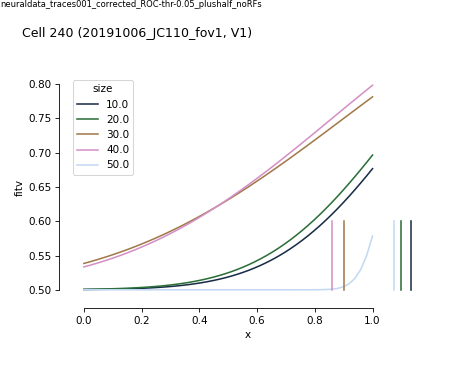

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/examples fitcurves_V1_20191006_JC110_fov1_rid240


In [327]:
fig, ax = pl.subplots(figsize=(6,5))
ax = plot_roi_fit(fparams, grouper='size', ax=ax, )


pl.subplots_adjust(left=0.15, right=0.95, bottom=0.2, wspace=0.5, top=0.8)

p3.label_figure(fig, data_id)
fig.text(0.05, 0.9, 'Cell %i (%s, %s)' % (rid, dk, va), fontsize=12)

figname = 'fitcurves_%s_%s_rid%03d' % (va, dk, rid)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [328]:
data_id

'neuraldata_traces001_corrected_ROC-thr-0.05_plushalf_noRFs'

In [329]:
    
def getDeviance(result,Nsamples=None):
    fit = result['Fit']
    data = result['data']
    pPred = fit[3] + (1-fit[2]-fit[3]) * result['options']['sigmoidHandle'](data[:,0], fit[0], fit[1])
    
    pMeasured = data[:,1]/data[:,2]
    loglikelihoodPred = data[:,1]*np.log(pPred)+(data[:,2]-data[:,1])*np.log((1-pPred))
    loglikelihoodMeasured = data[:,1]*np.log(pMeasured)+(data[:,2]-data[:,1])*np.log((1-pMeasured))
    loglikelihoodMeasured[pMeasured==1] = 0;
    loglikelihoodMeasured[pMeasured==0] = 0;

    #devianceResiduals = -2*np.sign(pMeasured-pPred)*(loglikelihoodMeasured - loglikelihoodPred)
    #deviance = np.sum(np.abs(devianceResiduals))
    devianceResiduals = np.sign(pMeasured-pPred)*np.sqrt(2*(loglikelihoodMeasured - loglikelihoodPred))
    deviance = np.sum(devianceResiduals**2)
    
    if Nsamples is None:
        return devianceResiduals,deviance
    else: 
        r_vals=[]
        samples_devianceResiduals = np.zeros((Nsamples,data.shape[0]))
        for iData in range(data.shape[0]):
            samp_dat = np.random.binomial(data[iData,2],pPred[iData],Nsamples)
            #print(samp_dat)
            pMeasured = samp_dat/data[iData,2]
            #print(pMeasured)
            loglikelihoodPred = samp_dat*np.log(pPred[iData])+(data[iData,2]-samp_dat)*np.log(1-pPred[iData])
            loglikelihoodMeasured = samp_dat*np.log(pMeasured)+(data[iData,2]-samp_dat)*np.log(1-pMeasured)
            loglikelihoodMeasured[pMeasured==1] = 0
            loglikelihoodMeasured[pMeasured==0] = 0
            #samples_devianceResiduals[:,iData] = -2*np.sign(pMeasured-pPred[iData])*(loglikelihoodMeasured - loglikelihoodPred)
            samples_devianceResiduals[:,iData] = np.sign(pMeasured-pPred[iData])*np.sqrt(2.*(loglikelihoodMeasured - loglikelihoodPred))
        r_vals=[]
        for iS in range(Nsamples):
            sr = samples_devianceResiduals[iS, :]
            r, p = spstats.pearsonr(sr, pPred)
            r_vals.append(r)
            
        #samples_deviance = np.sum(np.abs(samples_devianceResiduals),axis=1)
        samples_deviance = np.sum(samples_devianceResiduals**2,axis=1)
        return devianceResiduals,deviance,samples_devianceResiduals,samples_deviance, r_vals


In [330]:
def get_empirical_ci(stat, ci=0.95):
    p = ((1.0-ci)/2.0) * 100
    lower = np.percentile(stat, p) #max(0.0, np.percentile(stat, p))
    p = (ci+((1.0-ci)/2.0)) * 100
    upper = np.percentile(stat, p) # min(1.0, np.percentile(x0, p))
    #print('%.1f confidence interval %.2f and %.2f' % (alpha*100, lower, upper))
    return lower, upper

In [331]:
fitopts = p3.default_options()
fitopts

{'expType': '2AFC', 'sigmoidName': 'gauss', 'threshPC': 0.5}

In [333]:
def getDeviance(result,Nsamples=None):
    fit = result['Fit']
    data = result['data']
    pPred = fit[3] + (1-fit[2]-fit[3]) * result['options']['sigmoidHandle'](data[:,0], fit[0], fit[1])
    
    pMeasured = data[:,1]/data[:,2]
    loglikelihoodPred = data[:,1]*np.log(pPred)+(data[:,2]-data[:,1])*np.log((1-pPred))
    loglikelihoodMeasured = data[:,1]*np.log(pMeasured)+(data[:,2]-data[:,1])*np.log((1-pMeasured))
    loglikelihoodMeasured[pMeasured==1] = 0;
    loglikelihoodMeasured[pMeasured==0] = 0;

    #devianceResiduals = -2*np.sign(pMeasured-pPred)*(loglikelihoodMeasured - loglikelihoodPred)
    #deviance = np.sum(np.abs(devianceResiduals))
    devianceResiduals = np.sign(pMeasured-pPred)*np.sqrt(2*(loglikelihoodMeasured - loglikelihoodPred))
    deviance = np.sum(devianceResiduals**2)
    
    if Nsamples is None:
        return devianceResiduals,deviance
    else: 
        r_vals=[]
        samples_devianceResiduals = np.zeros((Nsamples,data.shape[0]))
        for iData in range(data.shape[0]):
            samp_dat = np.random.binomial(data[iData,2],pPred[iData],Nsamples)
            #print(samp_dat)
            pMeasured = samp_dat/data[iData,2]
            #print(pMeasured)
            loglikelihoodPred = samp_dat*np.log(pPred[iData])+(data[iData,2]-samp_dat)*np.log(1-pPred[iData])
            loglikelihoodMeasured = samp_dat*np.log(pMeasured)+(data[iData,2]-samp_dat)*np.log(1-pMeasured)
            loglikelihoodMeasured[pMeasured==1] = 0
            loglikelihoodMeasured[pMeasured==0] = 0
            #samples_devianceResiduals[:,iData] = -2*np.sign(pMeasured-pPred[iData])*(loglikelihoodMeasured - loglikelihoodPred)
            samples_devianceResiduals[:,iData] = np.sign(pMeasured-pPred[iData])*np.sqrt(2.*(loglikelihoodMeasured - loglikelihoodPred))
        r_vals=[]
        for iS in range(Nsamples):
            sr = samples_devianceResiduals[iS, :]
            r, p = spstats.pearsonr(sr, pPred)
            r_vals.append(r)
            
        #samples_deviance = np.sum(np.abs(samples_devianceResiduals),axis=1)
        samples_deviance = np.sum(samples_devianceResiduals**2,axis=1)
        return devianceResiduals,deviance,samples_devianceResiduals,samples_deviance, r_vals


In [336]:
traceid_dir = p3.get_tracedir_from_datakey(dk)
roi_fit_fns = glob.glob(os.path.join(traceid_dir, 'neurometric', 'fits', sigmoid_dir, 'rid*.pkl'))
# print('%i of %i fit cells pass' % (len(g['cell'].unique()), len(roi_fit_fns)))
len(roi_fit_fns)

31

In [337]:
# R = {}
# for rfn in roi_fit_fns:
#     with open(rfn, 'rb') as f:
#         rd = pkl.load(f)

#     rid = int(os.path.splitext(os.path.split(rfn)[-1])[0][3:])
#     R[rid] = rd['results']

    
#print(va, dk)
curr_fits, R, curr_miss = p3.load_fitparams(dk, roi_list=None,
                             allow_negative=allow_negative, sigmoid=sigmoid, split_pupil=False,
                             return_dicts=True, return_missing=True)


In [339]:
len(R)

31

In [464]:
auc_ = auc_r[auc_r['size']==30]

opts = default_options()
opts['sigmoidName'] = 'neg_%s' % sig if int(auc_['Eff'].unique())<53 else sig
opts['sigmoidHandle'] = getSig.getSigmoidHandle(opts)

In [340]:

rid = 240
curr_sz = 40
res = R[rid][curr_sz]

d_resid, deviance, samples_d_resid, samples_d, r_vals = getDeviance(res, Nsamples=1000)
print(d_resid.shape, deviance.shape, samples_d_resid.shape, samples_d.shape)
print(deviance, d_resid)

(9,) () (1000, 9) (1000,)
2.6435016324150453 [-0.2090375   0.09217582  0.1834802   0.42973554  0.40993421  0.08335441
  1.01126741 -0.6236079  -0.88680796]


In [343]:
sizes = sorted(auc_r['size'].unique())

size_colors = dict((s, v) for s, v in zip(sizes, sns.color_palette('cubehelix', n_colors=len(sizes))))


In [345]:
assert deviance == np.sum(d_resid**2)
fit = res['Fit']
data = res['data']
pPred = fit[3] + (1-fit[2]-fit[3]) * res['options']['sigmoidHandle'](data[:,0], fit[0], fit[1])
data_r, data_p = spstats.pearsonr(pPred, d_resid)
ci_lo, ci_hi = get_empirical_ci(r_vals)

In [346]:
importlib.reload(ps.psigniplot)


<module 'psignifit.psigniplot' from '/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py'>

In [347]:
rid = 240
curr_r = R[rid]


In [350]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit'

In [355]:
if not os.path.exists(os.path.join(dst_dir, 'deviance')):
    os.makedirs(os.path.join(dst_dir, 'deviance'))

(9,) () (1000, 9) (1000,)
1.995711663213143 [-0.69096691 -0.18804522 -0.03923494  0.24559309  0.8142675   0.08956778
  0.43512237 -0.6525013  -0.36731006]


<IPython.core.display.Javascript object>


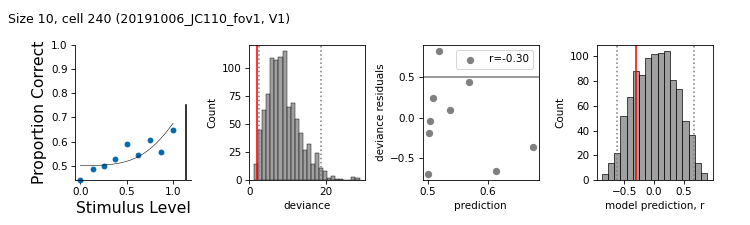

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


V1_20191006_JC110_fov1_rid240_deviance
(9,) () (1000, 9) (1000,)
3.735790433773893 [-0.87921847 -1.05438767 -0.58055169  0.73699208 -0.29010952  0.67858965
 -0.08110184  0.18973758 -0.61936182]


<IPython.core.display.Javascript object>


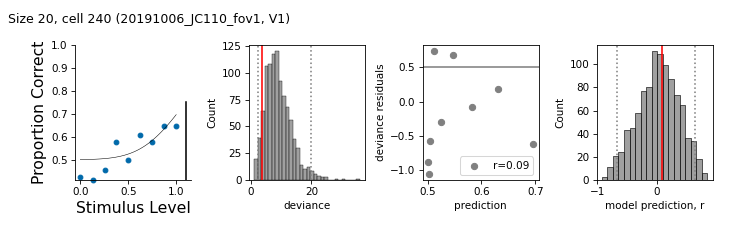

V1_20191006_JC110_fov1_rid240_deviance
(9,) () (1000, 9) (1000,)
7.532621413923643 [-0.44841316  0.23057787  0.34408608  1.50876179  0.91416372  0.77074596
 -1.52959173  0.23342915 -1.02943618]


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in multiply


<IPython.core.display.Javascript object>


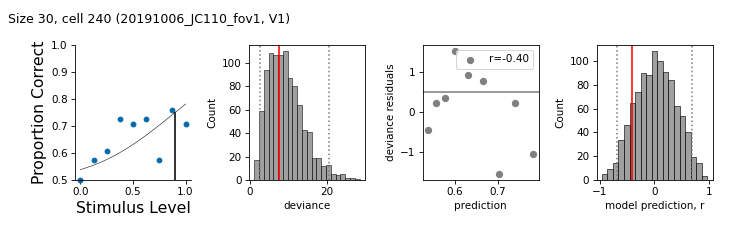

V1_20191006_JC110_fov1_rid240_deviance
(9,) () (1000, 9) (1000,)
2.6435016324150453 [-0.2090375   0.09217582  0.1834802   0.42973554  0.40993421  0.08335441
  1.01126741 -0.6236079  -0.88680796]


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in multiply


<IPython.core.display.Javascript object>


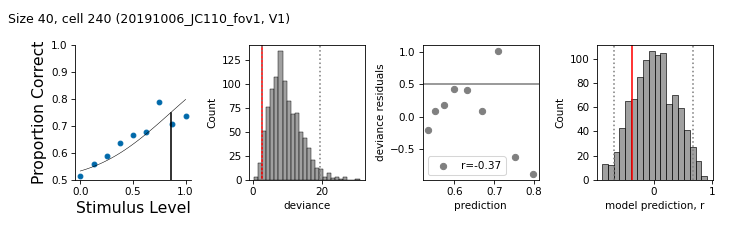

V1_20191006_JC110_fov1_rid240_deviance
(9,) () (1000, 9) (1000,)
12.990125167304953 [-1.03169219 -1.9333336   0.         -1.37844778 -1.72775002 -0.5225937
 -1.22321121 -1.23786806 -0.03243414]


<IPython.core.display.Javascript object>


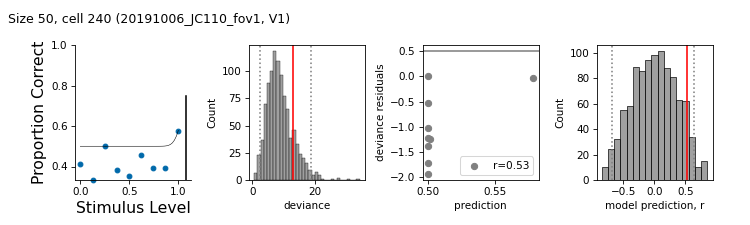

V1_20191006_JC110_fov1_rid240_deviance


In [356]:
for sz, auc_ in auc_r.groupby(['size']):
#auc_ = auc_r[auc_r['size']==sz]

    res = curr_r[sz]
    
    opts = p3.default_options()
    opts['sigmoidName'] = 'neg_%s' % sig if int(auc_['Eff'].unique())<53 else sig
    opts['sigmoidHandle'] = getSig.getSigmoidHandle(opts)

    d_resid, deviance, samples_d_resid, samples_d, r_vals = getDeviance(res, Nsamples=1000)
    print(d_resid.shape, deviance.shape, samples_d_resid.shape, samples_d.shape)
    print(deviance, d_resid)

    assert deviance == np.sum(d_resid**2)
    fit = res['Fit']
    data = res['data']
    pPred = fit[3] + (1-fit[2]-fit[3]) * res['options']['sigmoidHandle'](data[:,0], fit[0], fit[1])
    data_r, data_p = spstats.pearsonr(pPred, d_resid)
    ci_lo, ci_hi = get_empirical_ci(r_vals)


    col='gray'
    thresh_height=0.5
    npoints=50

    fig,axn=pl.subplots(1,4, figsize=(10,3))
    ax=axn[0]
    ax = ps.psigniplot.plotPsych(res, axisHandle=ax, plotData=True, lineWidth=0.5, plotAsymptote=False,
                                   thresh_height=None, npoints=npoints, extrapolLength=0, dataSize=5)

    ax=axn[1]
    sns.histplot(data=samples_d, ax=ax, color=col)
    ax.axvline(x=deviance, color='r')
    ax.set_xlabel('deviance')
    ci_lo, ci_hi = get_empirical_ci(samples_d)
    for ci in [ci_lo, ci_hi]:
        ax.axvline(x=ci, color=col, linestyle=':')
        
        
    ax=axn[2]
    ax.scatter(pPred, d_resid, label='r=%.2f' % data_r, c=col)
    ax.legend()
    ax.set_xlabel('prediction')
    ax.set_ylabel('deviance residuals')
    ax.axhline(y=0.5, color='gray')

    ax=axn[3]
    sns.histplot(data=r_vals, ax=ax, color=col)
    ci_lo, ci_hi = get_empirical_ci(r_vals)
    ax.axvline(x=data_r, color='r')
    for ci in [ci_lo, ci_hi]:
        ax.axvline(x=ci, color=col, linestyle=':')
    ax.set_xlabel('model prediction, r')

    pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, wspace=0.5, top=0.8)

    fig.text(0.01, 0.9, 'Size %i, cell %i (%s, %s)' % (sz, rid, dk, va), fontsize=12)

    figname = '%s_%s_rid%03d_deviance' % (va, dk, rid)
    pl.savefig(os.path.join(dst_dir, 'deviance', '%s.svg' % figname))
    print(figname)

In [349]:
curr_dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/examples'

In [361]:
mean_params = roifits.groupby(['visual_area', 'datakey', 'cell', 'size']).mean().reset_index()
mean_params.shape

(6925, 11)

In [174]:
sorted(passAUC['size'].unique())

[10.0, 20.0, 30.0, 40.0, 50.0]

## Selectivity vs. biases

In [400]:
print("... getting SELECTIVE only")
s_=[]
for (va, dk), g in roifits.groupby(['visual_area', 'datakey']):
    curr_cells_auc = g['cell'].unique()

    curr_cells_sel = selective_df[(selective_df.visual_area==va) & (selective_df.datakey==dk)]['cell'].unique()
    sel_and_auc = np.intersect1d(curr_cells_auc, curr_cells_sel)
    s_.append(g[g['cell'].isin(sel_and_auc)])

pPAR = pd.concat(s_, axis=0).reset_index(drop=True)

pass_selective = [(v, k, r) for (v, k, r), g in pPAR.groupby(['visual_area', 'datakey', 'cell'])]


... getting SELECTIVE only


In [403]:
len(pass_selective)

1043

In [401]:
mean_par = pPAR.groupby(['visual_area', 'datakey', 'cell', 'Eff']).mean().reset_index()
mean_par.shape

(1043, 12)

In [404]:
pSEL = pd.concat([g for (v, k, r), g in\
                            selective_df.groupby(['visual_area', 'datakey', 'cell']) \
                           if (v, k, r) in pass_selective])

mean_sel = pSEL.groupby(['visual_area', 'datakey', 'cell']).mean().reset_index()
mean_sel.shape

(1043, 5)

In [405]:
mean_sel.head()

visual_area              datakey   cell  size    sel_ix
0          Li  20190315_JC070_fov1  183.0  30.0 -0.004310
1          Li  20190315_JC070_fov1  187.0  30.0 -0.002171
2          Li  20190315_JC070_fov1  191.0  30.0 -0.003764
3          Li  20190315_JC070_fov1  222.0  30.0 -0.007101
4          Li  20190315_JC070_fov1  227.0  30.0 -0.003682

In [407]:
mean_par.head()

visual_area              datakey  cell  Eff  threshold     width  \
0          Li  20190315_JC070_fov1   183  106   1.082144  1.173027   
1          Li  20190315_JC070_fov1   187  106   1.123884  0.792606   
2          Li  20190315_JC070_fov1   191  106   1.032425  0.943956   
3          Li  20190315_JC070_fov1   222  106   0.848311  0.941982   
4          Li  20190315_JC070_fov1   227  106   0.835538  0.699802   

         lambda  gamma       eta     slope       thr  size  
0  4.287608e-05    0.5  0.027265  1.303483  1.082206  30.0  
1  5.073682e-08    0.5  0.000006  1.702739  1.123884  30.0  
2  5.641432e-06    0.5  0.000079  1.747229  1.032426  30.0  
3  6.692819e-02    0.5  0.052650  1.526831  1.056572  30.0  
4  6.251383e-02    0.5  0.000029  1.687276  1.053422  30.0

In [413]:
# mean_sel = mean_sel.rename(columns={'Eff': 'object'})
passdf = pd.merge(mean_par, mean_sel)
passdf['abs_ix'] = passdf['sel_ix'].abs()
passdf['abs_thr'] = np.abs(passdf['threshold'] - 0.5)

print(passdf.shape)
passdf.head()

(1043, 15)


visual_area              datakey  cell  Eff  threshold     width  \
0          Li  20190315_JC070_fov1   183  106   1.082144  1.173027   
1          Li  20190315_JC070_fov1   187  106   1.123884  0.792606   
2          Li  20190315_JC070_fov1   191  106   1.032425  0.943956   
3          Li  20190315_JC070_fov1   222  106   0.848311  0.941982   
4          Li  20190315_JC070_fov1   227  106   0.835538  0.699802   

         lambda  gamma       eta     slope       thr  size    sel_ix  \
0  4.287608e-05    0.5  0.027265  1.303483  1.082206  30.0 -0.004310   
1  5.073682e-08    0.5  0.000006  1.702739  1.123884  30.0 -0.002171   
2  5.641432e-06    0.5  0.000079  1.747229  1.032426  30.0 -0.003764   
3  6.692819e-02    0.5  0.052650  1.526831  1.056572  30.0 -0.007101   
4  6.251383e-02    0.5  0.000029  1.687276  1.053422  30.0 -0.003682   

     abs_ix   abs_thr  
0  0.004310  0.582144  
1  0.002171  0.623884  
2  0.003764  0.532425  
3  0.007101  0.348311  
4  0.003682  0.335538

<IPython.core.display.Javascript object>


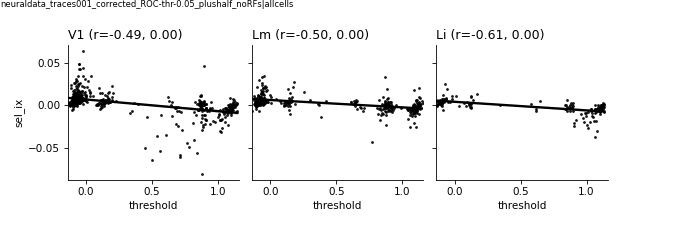

In [431]:
fg = sns.lmplot(col='visual_area', x='threshold', y='sel_ix', data=passdf, height=3,
           scatter_kws={'color':'k', 's': 3}, markers='o', line_kws={'color': 'k'},
          col_order=visual_areas)
fg.set_titles('')

for va, g in passdf.groupby(['visual_area']):
    xv = g['threshold'].values
    yv =  g['sel_ix'].values
    pears_r, pears_p = spstats.pearsonr(xv, yv)
    ai = visual_areas.index(va)
    fg.axes.flat[ai].set_title('%s (r=%.2f, %.2f)' % (va, pears_r, pears_p), loc='left')
    
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

p3.label_figure(fg.fig, '%s|%s' % (data_id, selective_str))

# figname = 'lmplot_SELvTHR_%s-crit-%.2f__%s' % (selective_str, criterion, responsive_test)
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
# print(dst_dir, figname)



<IPython.core.display.Javascript object>


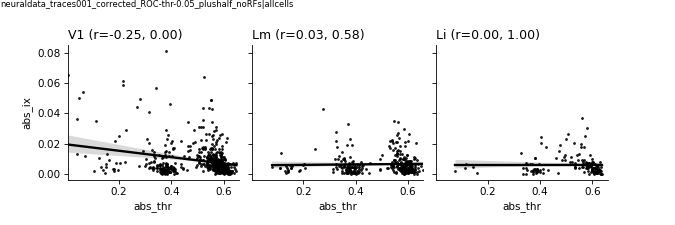

In [415]:
fg = sns.lmplot(col='visual_area', x='abs_thr', y='abs_ix', data=passdf, height=3,
          scatter_kws={'color':'k', 's': 3}, markers='o', line_kws={'color': 'k'},
          col_order=visual_areas)

fg.set_titles('')

for va, g in passdf.groupby(['visual_area']):
    xv = g['abs_thr'].values
    yv =  g['abs_ix'].values
    pears_r, pears_p = spstats.pearsonr(xv, yv)
    ai = visual_areas.index(va)
    fg.axes.flat[ai].set_title('%s (r=%.2f, %.2f)' % (va, pears_r, pears_p), loc='left')
    
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

p3.label_figure(fg.fig, '%s|%s' % (data_id, selective_str))

# figname = 'lmplot_absSELvTHR_%s-crit-%.2f__%s' % (selective_str, criterion, responsive_test)
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
# print(dst_dir, figname)


In [ ]:
glob.glob(os.path.join(traceid_dir, 'neurometric', 'aucs', '%s.pkl' % curr_results_id))

# test 1 cell/fov

## Load split trial input data

In [ ]:

dst_dir = os.path.join(traceid_dir, 'neurometric', 'aucs')
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)

    
sdf = SDF[dk].copy()


morph_lut, a_morphs, b_morphs = get_morph_levels()

ndf = DATA[(DATA.visual_area==va) & (DATA.datakey==dk)].copy()
ndf = add_morph_info(ndf, sdf, morph_lut, a_morphs, b_morphs)
    

curr_results_id = decode_analysis_id(visual_area=va, responsive_test=responsive_test,
                       response_type='dff', overlap_str='noRF', trial_epoch='plushalf')

print(curr_results_id)

traceid_dir = get_tracedir_from_datakey(dk)
dst_dir = os.path.join(traceid_dir, 'neurometric', 'aucs')
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)


decoding_outfile = os.path.join(traceid_dir, 'decoding', 'inputdata_%s.pkl' % curr_results_id)
assert os.path.exists(decoding_outfile),\
        "(%s, %s) No <%s> results: %s" % (dk, va, decode_prefix, results_id)

with open(decoding_outfile, 'rb') as f:
    indata = pkl.load(f, encoding='latin1')
trialdf = indata['input_trials']


In [359]:
rid = 217

auc_r = mean_auc[mean_auc['cell']==rid].copy().reset_index(drop=True)
auc_r['n_chooseB'] = auc_r['AUC']*auc_r['n_trials']


In [360]:
auc_r.dtypes

cell            int64
morphlevel      int64
size          float64
arousal        object
iteration       int64
AUC           float64
n_trials        int64
Eff             int64
n_chooseB     float64
dtype: object

            trial     response     baseline     size  morphlevel  morphstep  \
object                                                                        
A       666.90625  1177.519314  1053.120576  30.3125         0.0        4.0   
B       693.53125  1120.601193  1072.330808  30.3125       106.0        4.0   

        morph_ix  
object            
A            0.0  
B            1.0  
(45, 50) (5, 50) 45


<IPython.core.display.Javascript object>


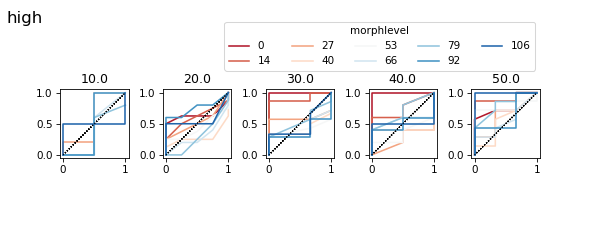

            trial     response    baseline     size  morphlevel  morphstep  \
object                                                                       
A       861.28125  1134.037619  1050.25437  30.3125         0.0        4.0   
B       863.18750  1096.068005  1062.43037  30.3125       106.0        4.0   

        morph_ix  
object            
A            0.0  
B            1.0  
(45, 50) (5, 50) 45


<IPython.core.display.Javascript object>


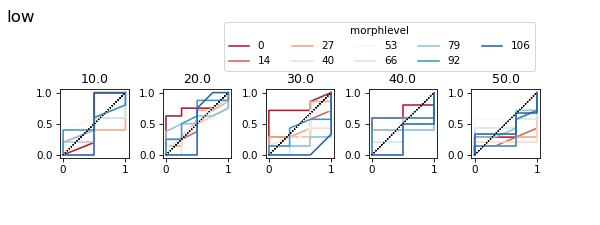

In [284]:
# a_cond='high'
# a_df = curr_trials[(curr_trials['iteration']==0) & (curr_trials.arousal==a_cond)].copy()

for a_cond, a_df in curr_trials[(curr_trials['iteration']==0)].groupby(['arousal']):
    curr_rdf = ndf[ndf['trial'].isin(a_df['trial'].values) & (ndf['cell']==rid)].copy()

    fig = plot_auc_for_cell(curr_rdf, param='morphlevel', class_a=0, class_b=106, cmap='RdBu')
    fig.text(0.01, 0.9, a_cond, fontsize=16)

In [364]:
auc_r

cell  morphlevel  size arousal  iteration       AUC  n_trials  Eff  \
0       217           0  10.0    high          0  0.000000         5    0   
1       217           0  10.0    high          1  0.500000         5    0   
2       217           0  10.0    high          2  0.450000         5    0   
3       217           0  10.0    high          3  0.550000         5    0   
4       217           0  10.0    high          4  1.000000         5    0   
...     ...         ...   ...     ...        ...       ...       ...  ...   
18355   217         106  50.0     low        199  0.444444         7    0   
18356   217         106  50.0     low        200  0.833333         7    0   
18357   217         106  50.0     low        201  0.444444         7    0   
18358   217         106  50.0     low        202  0.444444         7    0   
18359   217         106  50.0     low        203  0.888889         7    0   

       n_chooseB  
0       0.000000  
1       2.500000  
2       2.250000  
3       2.750000  
4       5.000000  
...          ...  
18355   3.111111  
18356   5.833333  
18357   3.111111  
18358   3.111111  
18359   6.222222  

[18360 rows x 9 columns]

<IPython.core.display.Javascript object>


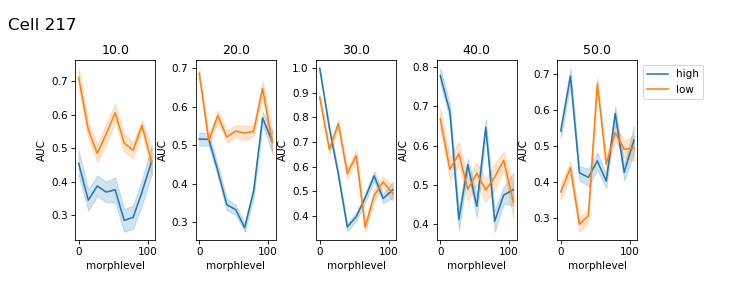

In [366]:
fig, axn = pl.subplots(1,len(sizes), figsize=(10,4))
for ax, (sz, sg) in zip(axn.flat, auc_r.groupby(['size'])):
    sns.lineplot(x='morphlevel', y='AUC', hue='arousal', data=sg, ax=ax)
    ax.legend_.remove()
    ax.set_title(sz)
    
axn[-1].legend(bbox_to_anchor=(1,1), loc='upper left')
fig.text(0.01, 0.9, 'Cell %i' % rid, fontsize=16)
pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, top=0.8, wspace=0.5)

In [335]:
ts = curr_trials[(curr_trials['iteration']==0) & (curr_trials['arousal']=='high')]['trial'].values

ndf[(ndf['trial'].isin(ts)) & (ndf['cell']==rid)].sort_values(by='config').groupby(['config']).count()

datakey  trial  visual_area  cell  response  baseline  size  \
config                                                                   
config006        5      5            5     5         5         5     5   
config007        8      8            8     8         8         8     8   
config008        7      7            7     7         7         7     7   
config009        5      5            5     5         5         5     5   
config010        7      7            7     7         7         7     7   
config011        5      5            5     5         5         5     5   
config012        8      8            8     8         8         8     8   
config013        7      7            7     7         7         7     7   
config014        5      5            5     5         5         5     5   
config015        7      7            7     7         7         7     7   
config016        5      5            5     5         5         5     5   
config017        8      8            8     8         8         8     8   
config018        7      7            7     7         7         7     7   
config019        5      5            5     5         5         5     5   
config020        7      7            7     7         7         7     7   
config021        5      5            5     5         5         5     5   
config022        8      8            8     8         8         8     8   
config023        6      6            6     6         6         6     6   
config024        5      5            5     5         5         5     5   
config025        7      7            7     7         7         7     7   
config026        5      5            5     5         5         5     5   
config027        8      8            8     8         8         8     8   
config028        7      7            7     7         7         7     7   
config029        5      5            5     5         5         5     5   
config030        7      7            7     7         7         7     7   
config031        5      5            5     5         5         5     5   
config032        5      5            5     5         5         5     5   
config033        7      7            7     7         7         7     7   
config034        5      5            5     5         5         5     5   
config035        7      7            7     7         7         7     7   
config036        5      5            5     5         5         5     5   
config037        8      8            8     8         8         8     8   
config038        7      7            7     7         7         7     7   
config039        5      5            5     5         5         5     5   
config040        7      7            7     7         7         7     7   
config041        5      5            5     5         5         5     5   
config042        5      5            5     5         5         5     5   
config043        7      7            7     7         7         7     7   
config044        5      5            5     5         5         5     5   
config045        7      7            7     7         7         7     7   
config046        5      5            5     5         5         5     5   
config047        8      8            8     8         8         8     8   
config048        7      7            7     7         7         7     7   
config049        5      5            5     5         5         5     5   
config050        7      7            7     7         7         7     7   

           morphlevel  morphstep  morph_ix  object  
config                                              
config006           5          5         5       5  
config007           8          8         8       8  
config008           7          7         7       7  
config009           5          5         5       5  
config010           7          7         7       7  
config011           5          5         5       5  
config012           8          8         8       8  
config013           7          7         7       7  
co

In [362]:
auc_r.head()

cell  morphlevel  size arousal  iteration   AUC  n_trials  Eff  n_chooseB
0   217           0  10.0    high          0  0.00         5    0       0.00
1   217           0  10.0    high          1  0.50         5    0       2.50
2   217           0  10.0    high          2  0.45         5    0       2.25
3   217           0  10.0    high          3  0.55         5    0       2.75
4   217           0  10.0    high          4  1.00         5    0       5.00

# Calculate AUC as performance

In [92]:
AUC = aggregate_AUC(DATA, SDF, param='morphlevel', midp=53, reverse_eff=False,
                  selective_only=False, selective_df=None, create_new=False)

... creating new AUC dfs


In [173]:
mAUC

cell  level_1  index       AUC  morphlevel  size  Eff  n_trials  \
0        113        0      0  0.590000           0  10.0    0        30   
1        113        1      1  0.543333          14  10.0    0        30   
2        113        2      2  0.596667          27  10.0    0        30   
3        113        3      3  0.523333          40  10.0    0        30   
4        113        4      4  0.644444          53  10.0    0        30   
...      ...      ...    ...       ...         ...   ...  ...       ...   
134175   390       40     35  0.666090          53  50.0  106        34   
134176   390       41     36  0.524955          66  50.0  106        33   
134177   390       42     37  0.672014          79  50.0  106        33   
134178   390       43     38  0.628342          92  50.0  106        33   
134179   390       44     39  0.683601         106  50.0  106        33   

       visual_area              datakey  
0               Li  20190315_JC070_fov1  
1               Li  20190315_JC070_fov1  
2               Li  20190315_JC070_fov1  
3               Li  20190315_JC070_fov1  
4               Li  20190315_JC070_fov1  
...            ...                  ...  
134175          V1  20191006_JC110_fov1  
134176          V1  20191006_JC110_fov1  
134177          V1  20191006_JC110_fov1  
134178          V1  20191006_JC110_fov1  
134179          V1  20191006_JC110_fov1  

[134180 rows x 10 columns]

In [25]:
importlib.reload(p3)

<module 'functools3' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/functools3.py'>

In [55]:
va='V1'
dk = '20190507_JC083_fov1'
midp=53
ndf = DATA[(DATA.visual_area==va) & (DATA.datakey==dk)].copy()
sdf = SDF[dk]

In [57]:
morphlevels = sdf['morphlevel'].unique()
max_morph = max(morphlevels)

assert midp in  morphlevels, "... Unknown midpoint in morphs: %s" % str(morphlevels)

morph_lut, a_morphs, b_morphs = p3.get_morph_levels(levels=morphlevels, midp=midp)
ndf = p3.add_morph_info(ndf, sdf, morph_lut, a_morphs, b_morphs, midp=53)
    
# ndf['size'] = [sdf['size'][c] for c in ndf['config']]
# ndf['morphlevel'] = [sdf['morphlevel'][c] for c in ndf['config']]
# ndf = ndf[(ndf['morphlevel']!=-1)].copy()

# morph_lut, a_morphs, b_morphs = get_morph_levels(levels=morphlevels, midp=midp)
# # update neuraldata
# ndf['morphstep'] = [morph_lut[m] for m in ndf['morphlevel']]
# ndf['morph_ix'] = [m/float(max_morph) for m in ndf['morphlevel']]

# ndf['object'] = None
# ndf.loc[ndf.morphlevel.isin(a_morphs), 'object'] = 'A'
# ndf.loc[ndf.morphlevel.isin(b_morphs), 'object'] = 'B'
# ndf.loc[ndf.morphlevel==midp, 'object'] = 'M'


In [58]:

# # get selective cells
# seldf = selective_df[(selective_df.visual_area==va) & (selective_df.datakey==dk)].copy()
# sel_cells = seldf['cell'].unique().astype(int)


In [59]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/fit_gauss_reverse'

In [60]:
rid = 8
rdf = ndf[ndf['cell']==rid].copy()


[0, 1, 2, 3, 4]


<IPython.core.display.Javascript object>


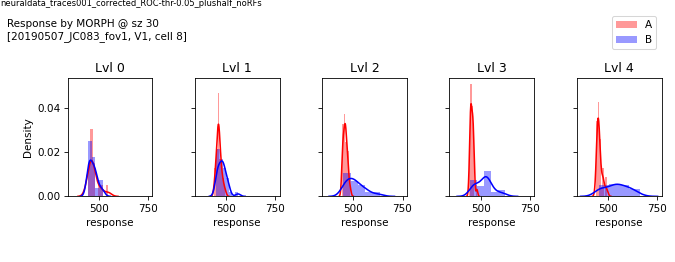

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figur

V1_20190507_JC083_fov1_rid008_sz30_PSTH_morphstep


In [80]:
plotparam = 'morphstep'
morph_levels=sorted(rdf[plotparam].unique())
print(morph_levels)
fig, axn = pl.subplots(1, len(morph_levels), sharex=True, sharey=True, figsize=(9,3.5))

curr_sz=30
for si, (sz, g) in enumerate(rdf[(rdf['size']==curr_sz) 
                                 & (rdf['morphlevel']!=-1)].groupby([plotparam])):
    ax=axn[si]
    if sz==0:
        if plotparam=='morphlevel':
            sns.distplot(g[g['object']=='A']['response'][0::2], ax=ax, color='r', label='A')
            sns.distplot(g[g['object']=='A']['response'][1::2], ax=ax, color='b', label='B')
        else:
            sns.distplot(g[g['object']=='M']['response'][0::2], ax=ax, color='r', label='A')
            sns.distplot(g[g['object']=='M']['response'][1::2], ax=ax, color='b', label='B')
    else:
        if plotparam=='morphlevel':
            sns.distplot(rdf[(rdf['size']==curr_sz) & (rdf[plotparam]==0)]['response'], ax=ax, color='r', label='A')
            sns.distplot(g['response'], ax=ax, color='b',label='B')
        else:
            sns.distplot(g[g['object']=='A']['response'], ax=ax, color='r',label='A')
            sns.distplot(g[g['object']=='B']['response'], ax=ax, color='b',label='B')

    ax.set_title('Lvl %i' % sz)
    
pl.subplots_adjust(left=0.1, right=0.98, bottom=0.25, top=0.7, wspace=0.5)
ax.legend(bbox_to_anchor=(1., 1.2), loc='lower right')
fig.text(0.01, 0.85, 'Response by MORPH @ sz %i\n[%s, %s, cell %i]' \
            % (curr_sz, dk, va, rid))

p3.label_figure(fig, data_id)
figname = '%s_%s_rid%03d_sz%i_PSTH_%s' % (va, dk, rid, curr_sz, plotparam)
pl.savefig(os.path.join(dst_dir, 'examples', '%s.svg' % figname))
print(figname)

In [73]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/fit_gauss_reverse'

In [92]:
sig='gauss'

class_a=0
class_b=106
include_ref=True
n_crit=20

rid = 8 #65 #217 #90 #217
assert rid in ndf['cell'].unique()
rdf = ndf[ndf['cell']==rid].copy()

means = rdf[rdf.morphlevel.isin([class_a, class_b])].groupby(['object']).mean()
Eff = class_a if means['response']['A'] > means['response']['B'] else class_b


param = 'morphlevel'
# reverse_eff = param!='morphstep'
aucs, p_hits, p_fas, resp_cfgs1 = p3.get_auc_AB(rdf, param=param, n_crit=50, allow_negative=allow_negative,
                  class_a=0, class_b=106, return_probs=True)

sigmoid_ = 'neg_%s' % sig if Eff==0 else sig
print(sigmoid_)

gauss


In [91]:
importlib.reload(p3)

<module 'functools3' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/functools3.py'>

In [84]:
# aucs = get_auc_AB(rdf, param=param, n_crit=50, reverse_eff=False,
#                   class_a=0, class_b=106, return_probs=False)


In [85]:
# p_fas[sizes.index(sz), :].shape

NameError: name 'p_fas' is not defined

<IPython.core.display.Javascript object>


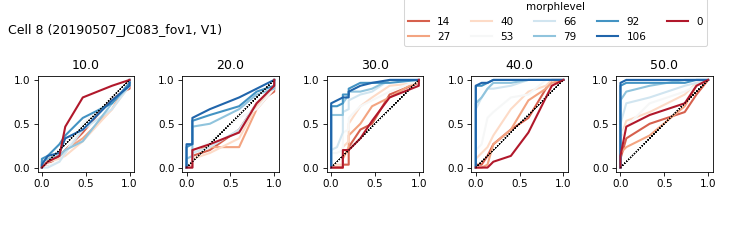

Text(0.01, 0.85, 'Cell 8 (20190507_JC083_fov1, V1)')

In [94]:
sizes = sorted(aucs['size'].unique())
cmap='plasma' if param=='morphstep' else 'RdBu'
lw=2
# Plot----
mdiffs = sorted(aucs[param].unique())
mdiff_colors = sns.color_palette(cmap, n_colors=len(mdiffs))
colors = dict((k, v) for k, v in zip(mdiffs, mdiff_colors))

fig, axn = pl.subplots(1, len(sizes), figsize=(10,3))    
for mi, (sz, mp) in enumerate(resp_cfgs1):
    si = sizes.index(sz)
    ax=axn[si]
    if param=='morphstep':
        ax.plot(p_fas[mi, :], p_hits[mi, :], color=colors[mp], label=mp, lw=lw)
    else:
        ax.plot(p_fas[si, :], p_hits[mi, :], color=colors[mp], label=mp, lw=lw)
    ax.set_title(sz)
    ax.set_aspect('equal')
    ax.plot([0, 1], [0, 1], linestyle=':', color='k', lw=1)
ax.legend(bbox_to_anchor=(1, 1.25), loc='lower right', title=param, ncol=5)
pl.subplots_adjust(left=0.05, right=0.95, bottom=0.2, hspace=0.5, wspace=0.5, top=0.7)
fig.text(0.01, 0.85, 'Cell %i (%s, %s)' % (rid, dk, va), fontsize=12)


In [29]:
importlib.reload(ps.psigniplot)

<module 'psignifit.psigniplot' from '/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py'>

In [79]:
# aucs, p_hits, p_fas, resp_cfgs1 = get_auc_AB(rdf, param=param, n_crit=50, reverse_eff=False,
#                   class_a=0, class_b=106, return_probs=True)

curr_sz=30
auc_ = aucs[aucs['size']==curr_sz].copy()
auc_['n_chooseB'] = auc_['AUC']*auc_['n_trials']
data_ = data_matrix_from_auc(auc_, param=param,normalize=True)
data_

array([[ 0.        , 28.        , 30.        ],
       [ 0.13207547, 24.        , 30.        ],
       [ 0.25471698, 23.        , 30.        ],
       [ 0.37735849, 20.        , 30.        ],
       [ 0.5       , 22.        , 30.        ],
       [ 0.62264151, 19.        , 30.        ],
       [ 0.74528302, 21.        , 30.        ],
       [ 0.86792453, 20.        , 30.        ],
       [ 1.        , 21.        , 30.        ]])

<IPython.core.display.Javascript object>


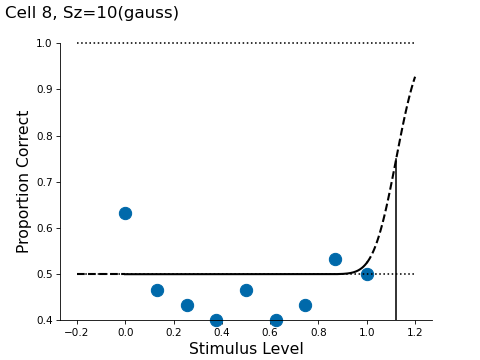

[1.12 0.24 0.   0.5  0.  ]


<IPython.core.display.Javascript object>


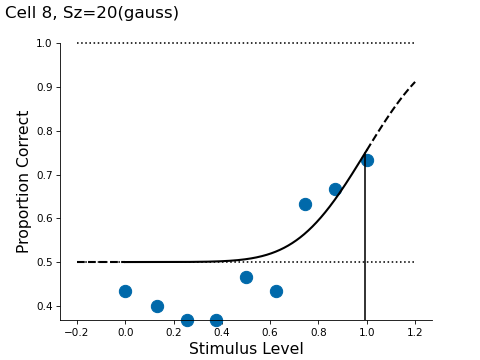

[0.99 0.73 0.   0.5  0.  ]


<IPython.core.display.Javascript object>


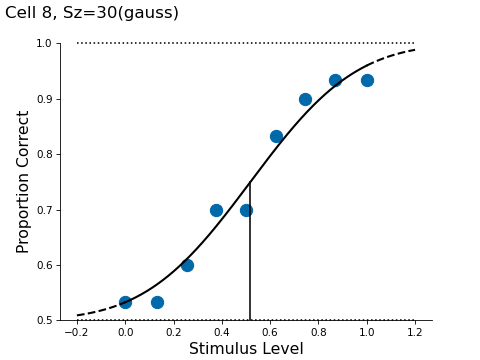

[0.52 1.13 0.   0.5  0.  ]


<IPython.core.display.Javascript object>


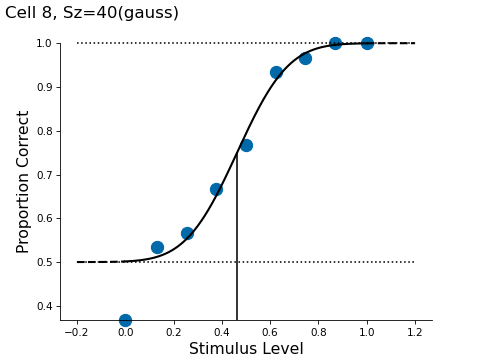

[0.46 0.55 0.   0.5  0.  ]


<IPython.core.display.Javascript object>


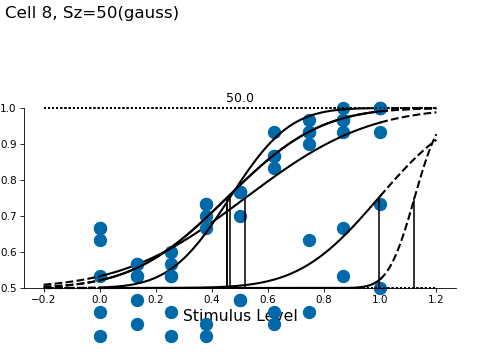

[0.45 0.86 0.   0.5  0.  ]


In [97]:

results={}
for curr_sz, auc_ in aucs.groupby(['size']):
    auc_ = aucs[aucs['size']==curr_sz].copy()
    auc_['n_chooseB'] = auc_['AUC']*auc_['n_trials']
    data_ = p3.data_matrix_from_auc(auc_, param=param,normalize=True)


    ni = 0
    opts = dict()
    opts['sigmoidName'] = sigmoid_

    opts['expType'] = '2AFC' #'2AFC'
    opts['threshPC'] = 0.5
    at_pc = 0.75 if opts['expType']=='2AFC' else 0.5
    res_ = ps.psignifit(data_, opts)
    print(res_['Fit'].round(2))
    # norm: [0.74 1.27 0.   0.5  0.  ]
    # gumbel: [0.76 1.18 0.   0.5  0.  ]
    # neg_gumbel: [0.16 0.69 0.   0.5  0.  ]

    # Weibull: [0.88 0.5  0.   0.5  0.  ]
    # [0.78 0.91 0.   0.5  0.  ]
    thr = ps.getThreshold(res_, at_pc)[0] # Value at which function reaches at_pc correct
    slp = ps.getSlope(res_, ps.getThreshold(res_, at_pc)[0]) # Slope at given stimulus level

    info_str = '(%i) %i (thr=%.2f,slope=%.2f)' % (ni, curr_sz, thr, slp)
    ax = ps.psigniplot.plotPsych(res_, axisHandle=ax, plotData=True, 
                                 lineColor='k', label=info_str)
    fig.text(0.01, 0.95, 'Cell %i, Sz=%i(%s)' % (rid, curr_sz, sigmoid_), fontsize=16)

    results[curr_sz] = res_

<IPython.core.display.Javascript object>


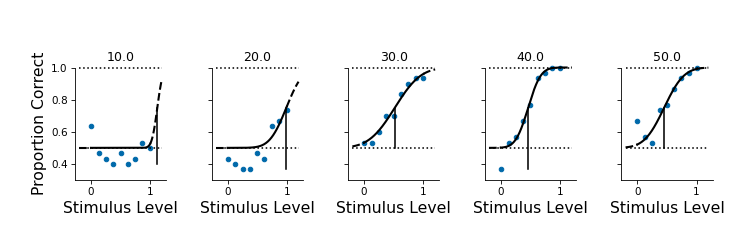

In [104]:
fig, axn = pl.subplots(1, len(sizes), figsize=(10,3), sharex=True, sharey=True)    

results[curr_sz] = res_
for curr_sz, res_ in results.items():
    ai = sizes.index(curr_sz)
    ax=axn[ai]
    ax = ps.psigniplot.plotPsych(res_, axisHandle=ax, plotData=True, 
                                 lineColor='k', label=info_str, dataSize=5)
    ax.set_title(curr_sz)
    if ai>0:
        ax.set_ylabel('')
    ax.set_ylim([0.3, 1])
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, hspace=0.5, wspace=0.5, top=0.7)


In [442]:
curr_fdir = os.path.join(curr_dst_dir, 'middle_thr')
if not os.path.exists(curr_fdir):
    os.makedirs(curr_fdir)
print(curr_fdir)

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/examples/middle_thr


In [435]:
B = onefit[(onefit['threshold']<=0.7) & (onefit['threshold']>=0.3)]
B

threshold     width        lambda  gamma           eta     slope  \
335    0.686359  1.794741  1.482067e-09    0.5  2.665707e-08  0.365625   
791    0.654198  1.900265  1.016213e-01    0.5  3.197070e-08 -0.260953   
1567   0.554792  1.188344  2.900773e-07    0.5  6.932014e-07  0.552198   
1568   0.561396  0.718166  4.549778e-02    0.5  4.901443e-10  0.824028   
1569   0.561142  0.465011  1.013230e-01    0.5  1.607858e-08  1.067613   
2074   0.676355  2.103228  1.912975e-07    0.5  3.333462e-06  0.311997   
2758   0.421500  1.969336  5.462827e-07    0.5  2.626881e-07 -0.333209   
2774   0.370833  1.773618  4.934650e-10    0.5  1.645039e-05 -0.369979   
3484   0.337220  1.464177  4.586619e-08    0.5  6.627823e-07 -0.448171   
3681   0.699913  2.099876  4.090629e-08    0.5  9.230547e-08  0.312495   
3687   0.556401  0.848384  2.442102e-02    0.5  2.227349e-09  0.734171   
3688   0.382836  0.674393  5.078619e-09    0.5  4.470198e-08  0.973025   
3689   0.498510  0.761894  1.654202e-06    0.5  6.696080e-10  0.861274   
3702   0.587796  0.361930  1.256958e-01    0.5  3.238132e-08  1.235207   
3703   0.661175  1.525423  8.372505e-09    0.5  5.151258e-10  0.430177   
3809   0.511059  1.978894  4.332252e-05    0.5  1.765681e-08  0.331571   
3853   0.434538  1.972895  4.238995e-07    0.5  4.535809e-10  0.332608   
3858   0.592316  1.757203  2.049216e-04    0.5  3.311967e-09  0.373282   
3989   0.330680  1.931851  3.740848e-05    0.5  1.062832e-09 -0.339650   
4013   0.579004  0.668581  4.801179e-02    0.5  2.511621e-09  0.879364   
4023   0.654253  1.105225  1.293824e-06    0.5  4.664777e-08  0.593725   
4024   0.528603  1.331363  3.671811e-08    0.5  2.495719e-07  0.492879   
4032   0.686355  1.528268  1.130286e-04    0.5  9.630824e-11  0.429279   
4207   0.344932  0.662654  1.577165e-01    0.5  2.323121e-09  0.561443   
4208   0.455906  0.243807  1.453686e-01    0.5  2.092368e-07  1.651123   
4326   0.665594  0.432380  1.599262e-01    0.5  2.928451e-07 -0.847270   
4354   0.340752  1.230491  9.837463e-09    0.5  7.699369e-10 -0.533284   
5019   0.321684  1.967102  0.000000e+00    0.5  0.000000e+00 -0.333588   
5317   0.694207  2.076621  3.469461e-09    0.5  9.098479e-08  0.315995   
6057   0.302880  1.259792  4.205647e-08    0.5  5.342828e-08 -0.520881   
6153   0.339918  2.235299  1.921864e-08    0.5  1.615589e-08 -0.293563   
6659   0.327636  2.002456  2.060662e-08    0.5  1.009655e-08 -0.327698   

           thr visual_area              datakey  cell  size  Eff  
335   0.686359          Li  20190602_JC091_fov1    89  10.0  106  
791   0.466260          Li  20190612_JC099_fov1   123  20.0    0  
1567  0.554792          Lm  20190504_JC078_fov1   194  30.0  106  
1568  0.588858          Lm  20190504_JC078_fov1   194  40.0  106  
1569  0.606956          Lm  20190504_JC078_fov1   194  50.0  106  
2074  0.676356          Lm  20190508_JC083_fov1   105  50.0  106  
2758  0.421499          Lm  20190517_JC083_fov1   117  40.0    0  
2774  0.370833          Lm  20190517_JC083_fov1   124  50.0    0  
3484  0.337220          Lm  20190627_JC091_fov1   163  50.0    0  
3681  0.699913          V1  20190507_JC083_fov1     5  20.0  106  
3687  0.573009          V1  20190507_JC083_fov1     8  30.0  106  
3688  0.382836          V1  20190507_JC083_fov1     8  40.0  106  
3689  0.498511          V1  20190507_JC083_fov1     8  50.0  106  
3702  0.635559          V1  20190507_JC083_fov1    14  30.0  106  
3703  0.661175          V1  20190507_JC083_fov1    14  40.0  106  
3809  0.511125          V1  20190507_JC083_fov1    85  50.0  106  
3853  0.434539          V1  20190507_JC083_fov1   126  40.0  106  
3858  0.592590          V1  20190507_JC083_fov1   128  40.0  106  
3989  0.330625          V1  20190509_JC078_fov1    83  50.0    0  
4013  0.606141          V1  20190510_JC083_fov1     9  40.0  106  
4023  0.654254          V1  20190510_JC083_fov1    20  40.0  106  
4024  0.528603          V1  20190510_JC083_fov1    20  50.0  106  
4032  0.686486        

Li 20190602_JC091_fov1 89 10.0 0.8345238095238096
240


<IPython.core.display.Javascript object>


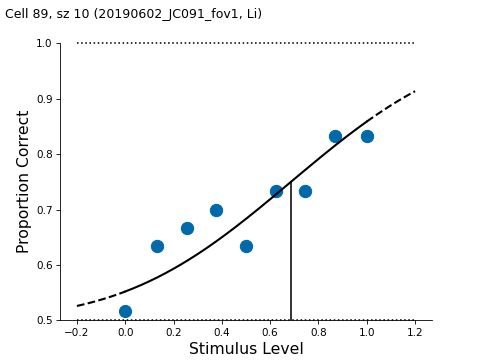

Li 20190612_JC099_fov1 123 20.0 0.8755555555555556
240


<IPython.core.display.Javascript object>


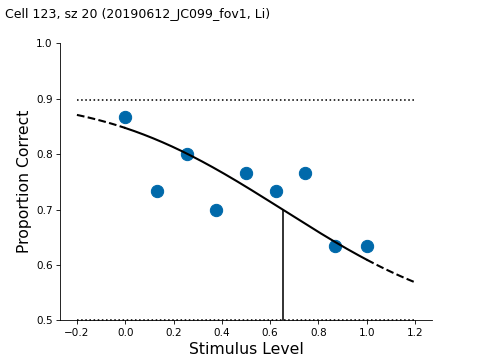

Lm 20190504_JC078_fov1 194 30.0 0.9366666666666666
240


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


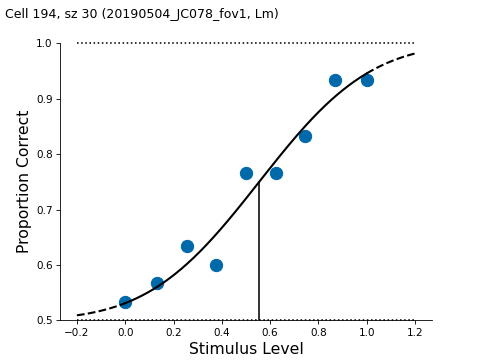

Lm 20190504_JC078_fov1 194 40.0 0.9311111111111111
240


<IPython.core.display.Javascript object>


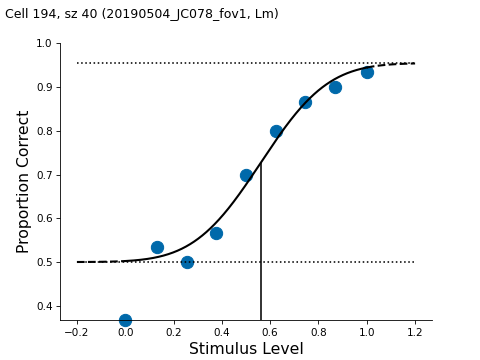

Lm 20190504_JC078_fov1 194 50.0 0.9133333333333333
240


<IPython.core.display.Javascript object>


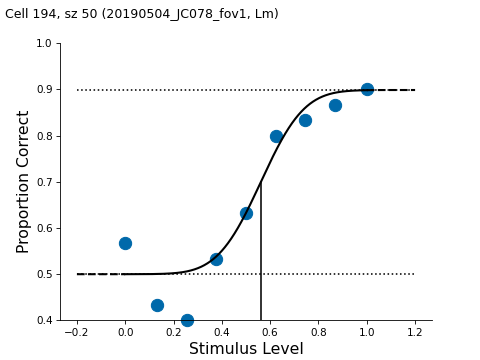

Lm 20190508_JC083_fov1 105 50.0 0.7857142857142857
240


<IPython.core.display.Javascript object>


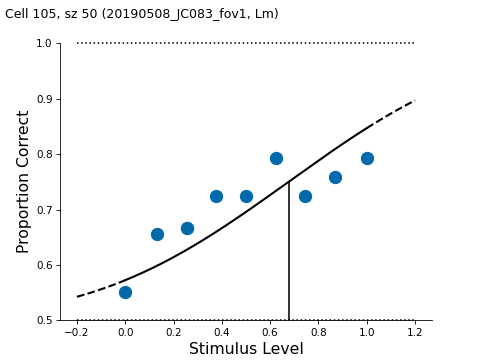

Lm 20190517_JC083_fov1 117 40.0 0.8666666666666667
240


<IPython.core.display.Javascript object>


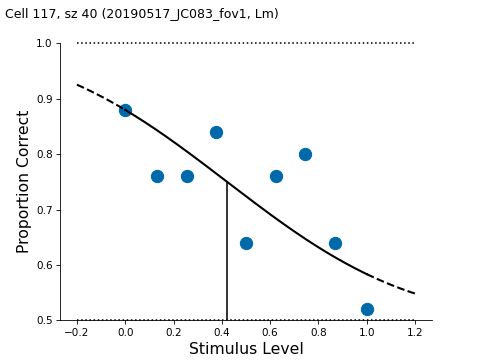

Lm 20190517_JC083_fov1 124 50.0 0.885
240


<IPython.core.display.Javascript object>


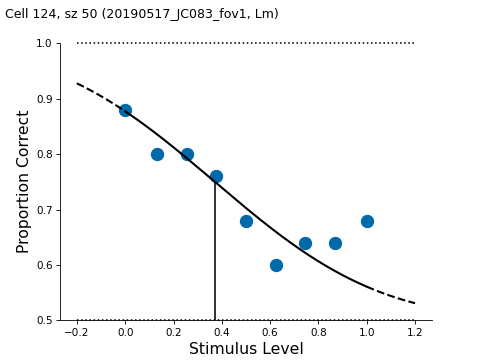

Lm 20190627_JC091_fov1 163 50.0 0.8433333333333334
240


<IPython.core.display.Javascript object>


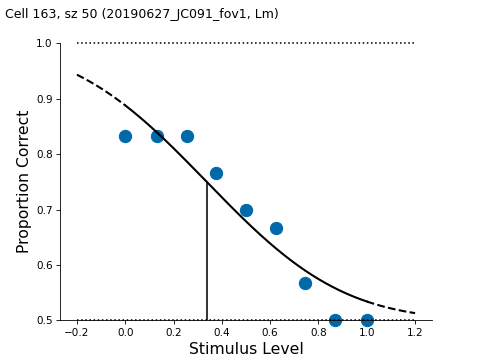

V1 20190507_JC083_fov1 5 20.0 0.7933333333333332
240


<IPython.core.display.Javascript object>


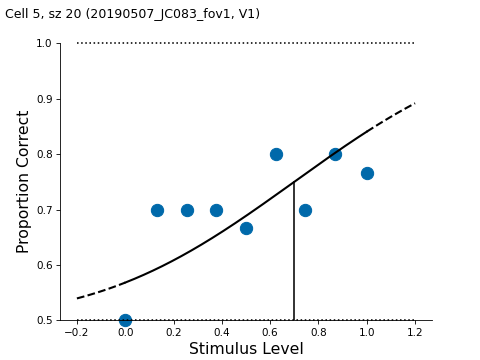

V1 20190507_JC083_fov1 8 30.0 0.9222222222222223
240


<IPython.core.display.Javascript object>


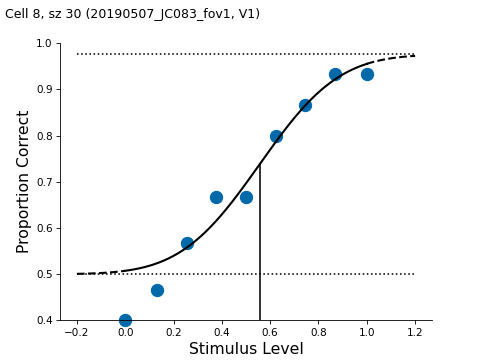

V1 20190507_JC083_fov1 8 40.0 0.9966666666666667
240


<IPython.core.display.Javascript object>


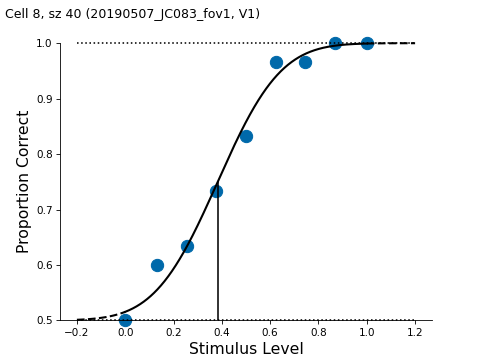

V1 20190507_JC083_fov1 8 50.0 0.9922222222222223
240


<IPython.core.display.Javascript object>


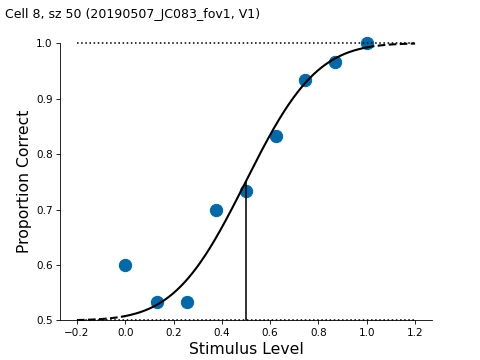

V1 20190507_JC083_fov1 14 30.0 0.8544444444444445
240


<IPython.core.display.Javascript object>


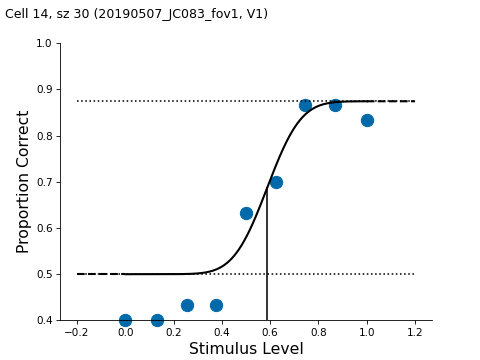

V1 20190507_JC083_fov1 14 40.0 0.8577777777777779
240


<IPython.core.display.Javascript object>


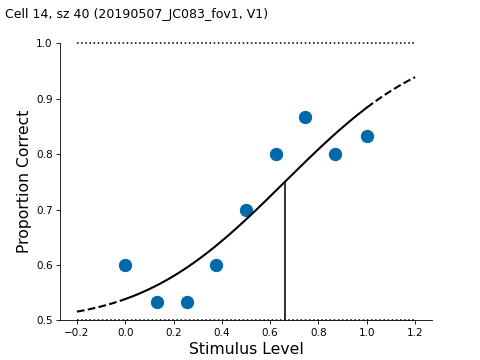

V1 20190507_JC083_fov1 85 50.0 0.8833333333333333
240


<IPython.core.display.Javascript object>


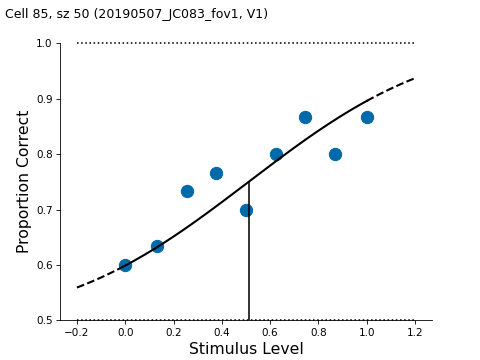

V1 20190507_JC083_fov1 126 40.0 0.8977777777777778
240


<IPython.core.display.Javascript object>


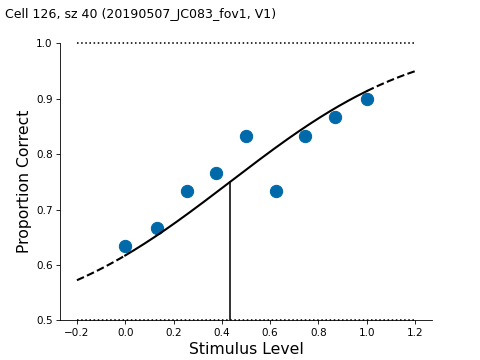

V1 20190507_JC083_fov1 128 40.0 0.8555555555555555
240


<IPython.core.display.Javascript object>


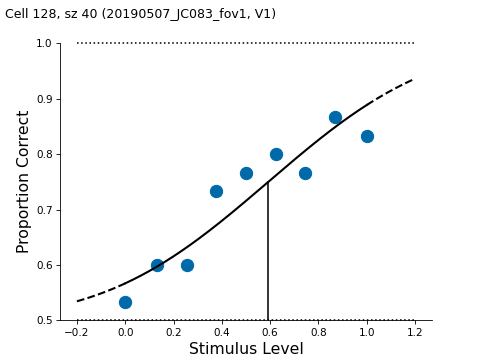

V1 20190509_JC078_fov1 83 50.0 0.82
240


<IPython.core.display.Javascript object>


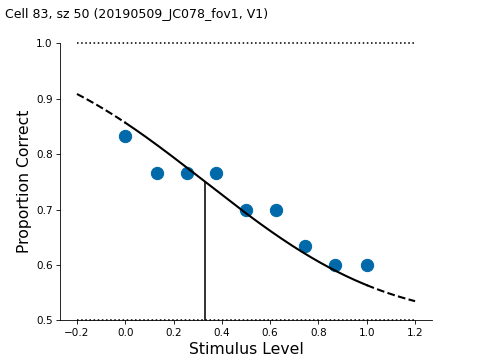

V1 20190510_JC083_fov1 9 40.0 0.9453781512605042
240


<IPython.core.display.Javascript object>


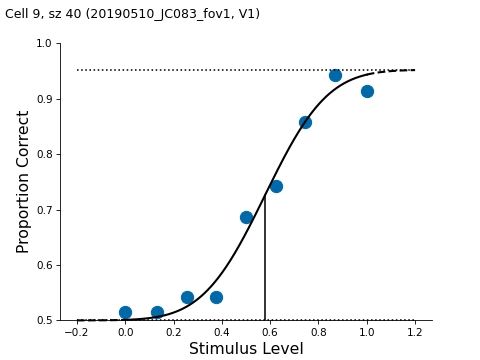

V1 20190510_JC083_fov1 20 40.0 0.8949579831932774
240


<IPython.core.display.Javascript object>


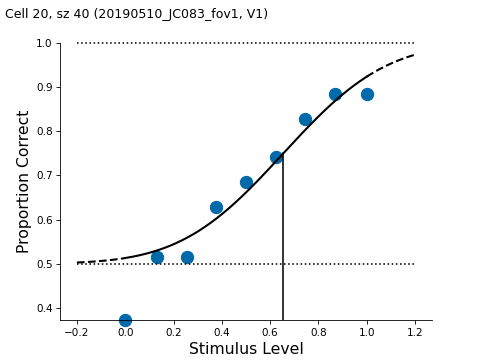

V1 20190510_JC083_fov1 20 50.0 0.9193277310924369
240


<IPython.core.display.Javascript object>


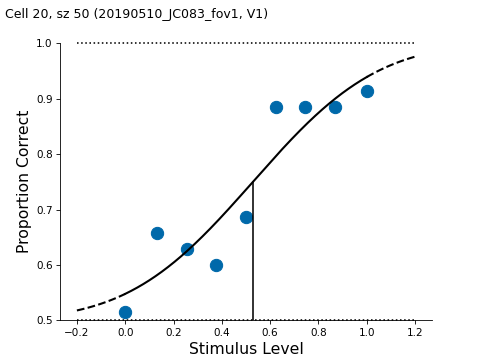

V1 20190510_JC083_fov1 23 30.0 0.8563025210084034
240


<IPython.core.display.Javascript object>


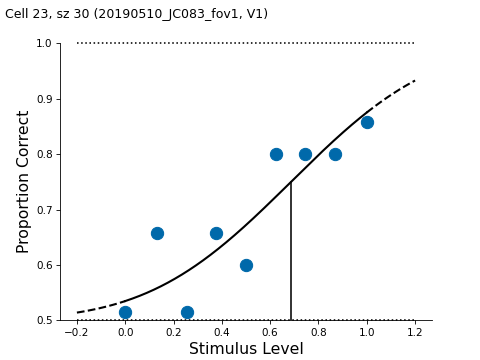

V1 20190511_JC083_fov1 32 30.0 0.8944444444444444
240


<IPython.core.display.Javascript object>


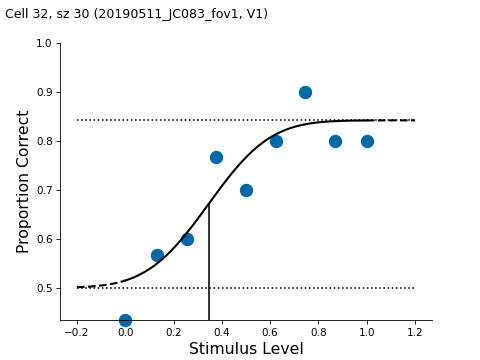

V1 20190511_JC083_fov1 32 40.0 0.9033333333333333
240


<IPython.core.display.Javascript object>


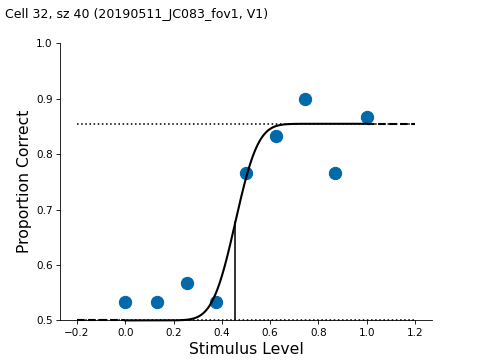

V1 20190511_JC083_fov1 119 20.0 0.8944444444444444
240


<IPython.core.display.Javascript object>


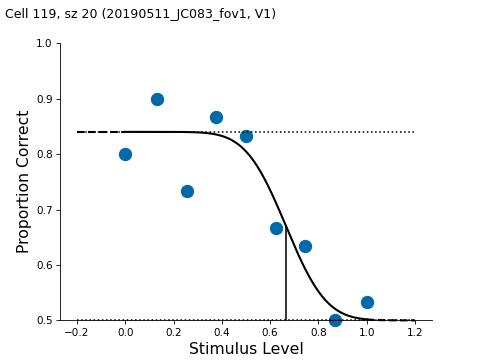

V1 20190511_JC083_fov1 143 50.0 0.9177777777777778
240


<IPython.core.display.Javascript object>


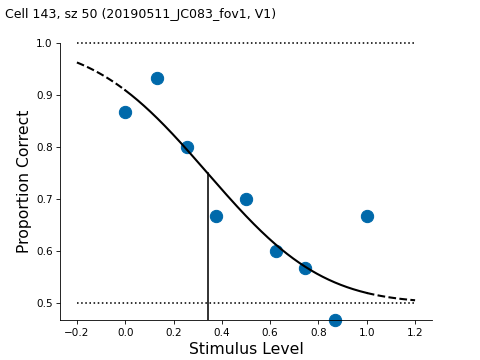

V1 20190613_JC097_fov1 125 50.0 0.8933333333333333
240


<IPython.core.display.Javascript object>


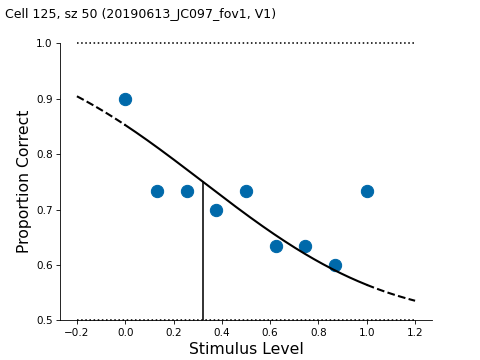

V1 20190616_JC097_fov1 147 30.0 0.81
240


<IPython.core.display.Javascript object>


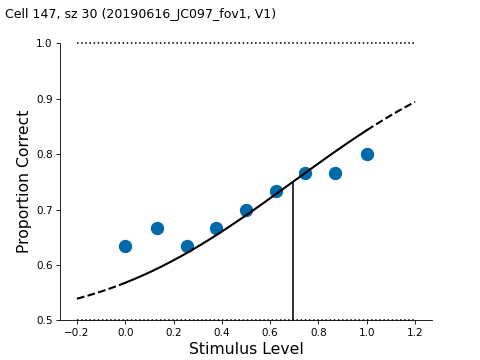

V1 20190617_JC097_fov1 254 30.0 0.95
240


<IPython.core.display.Javascript object>


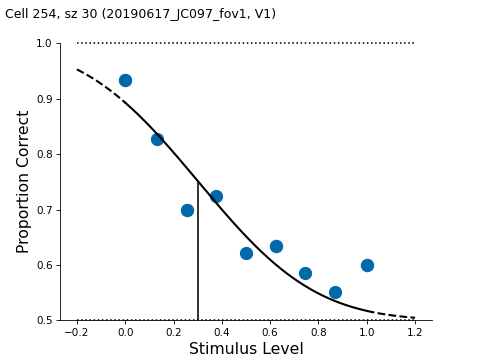

V1 20190617_JC097_fov1 414 40.0 0.8423645320197044
240


<IPython.core.display.Javascript object>


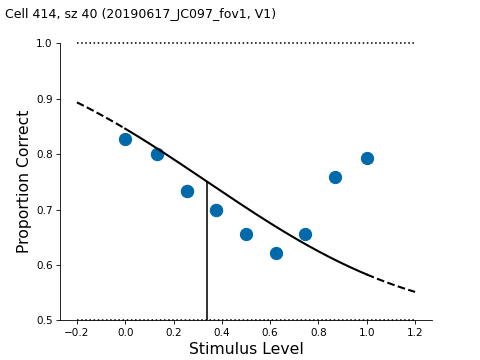

V1 20190622_JC085_fov1 335 50.0 0.8511111111111112
240


<IPython.core.display.Javascript object>


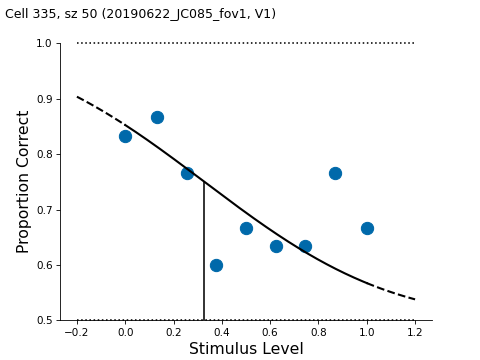

In [443]:
results={}
for (va,dk, ri, sz), g in B.groupby(['visual_area', 'datakey', 'cell', 'size']):
    
    mx = pAUC[(pAUC.visual_area==va) & (pAUC.datakey==dk) 
              & (pAUC['cell']==ri) & (pAUC['size']==sz)]['AUC'].max()
    print(va, dk, ri, sz, mx)

    traceid_dir = p3.get_tracedir_from_datakey(dk)
    sigmoid_dir='gauss'

    rfn = glob.glob(os.path.join(traceid_dir, 'neurometric', 'fits', 
                                         sigmoid_dir, 'rid%03d.pkl' % ri))[0]
    print(ri)
    with open(rfn, 'rb') as f:
        rd = pkl.load(f)
    k = '%s_%s_rid%03d_sz%i' % (va, dk, ri, sz)
    res = rd['results'][sz]
    results[k] = res

    fig, ax = pl.subplots()
    #res = results[rid][sz]
    # info_str = '(%i) %i (thr=%.2f,slope=%.2f)' % (ni, curr_sz, thr, slp)
    ax = ps.psigniplot.plotPsych(res, axisHandle=ax, plotData=True, 
                                 lineColor='k', label=rid)

    fig.text(0.01, 0.95, 'Cell %i, sz %i (%s, %s)' % (ri, sz, dk, va), fontsize=12)

    figname = 'fit_%s_%s_rid%03d_sz%i' % (va, dk, ri, sz)
    pl.savefig(os.path.join(curr_fdir, '%s.svg' % figname))

In [579]:
curr_dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/examples'

## Test loading

In [127]:
# Cells that pass performance criterion
pass_cells = currAUC[currAUC['AUC']>=max_auc]['cell'].unique()
print("%i of %i cells pass crit (%.2f)" % (len(pass_cells), len(currAUC['cell'].unique()), max_auc))
pass_auc = currAUC[currAUC['cell'].isin(pass_cells)].copy()
if len(pass_cells)==0:
    print("****[%s, %s] no cells." % (va, dk))


# Best config (size) for each cell
max_auc_ixs = pass_auc.groupby(['cell'])['AUC'].transform(max) == pass_auc['AUC']
ix = pass_auc[max_auc_ixs]['cell'].drop_duplicates().index.tolist()
best_sz_per_cell = [(r, c) for (r, c), g in pass_auc.loc[ix].groupby(['cell', 'size'])]
assert len(pass_cells)==len(best_sz_per_cell)
if len(best_sz_per_cell)==0:
    print("****[%s, %s] no cells." % (va, dk))

bes
t_auc = pd.concat([g for (r,c), g in pass_auc.groupby(['cell', 'size']) if (r, c) in best_sz_per_cell])


104 of 184 cells pass crit (0.70)


In [ ]:
    # Cells that pass performance criterion
    pass_cells = aucs[aucs['AUC']>=max_auc]['cell'].unique()
    print("%i of %i cells pass crit (%.2f)" % (len(pass_cells), len(aucs['cell'].unique()), max_auc))
    pass_auc = aucs[aucs['cell'].isin(pass_cells)].copy()
    if len(pass_cells)==0:
        print("****[%s, %s] no cells." % (va, dk))
        continue

    # Best config (size) for each cell
#     max_auc_ixs = pass_auc.groupby(['cell'])['AUC'].transform(max) == pass_auc['AUC']
#     ix = pass_auc[max_auc_ixs]['cell'].drop_duplicates().index.tolist()
#     best_sz_per_cell = [(r, c) for (r, c), g in pass_auc.loc[ix].groupby(['cell', 'size'])]
#     assert len(pass_cells)==len(best_sz_per_cell)
#     if len(best_sz_per_cell)==0:
#         print("****[%s, %s] no cells." % (va, dk))
#         continue
#     best_auc = pd.concat([g for (r,c), g in pass_auc.groupby(['cell', 'size']) if (r, c) in best_sz_per_cell])


<IPython.core.display.Javascript object>


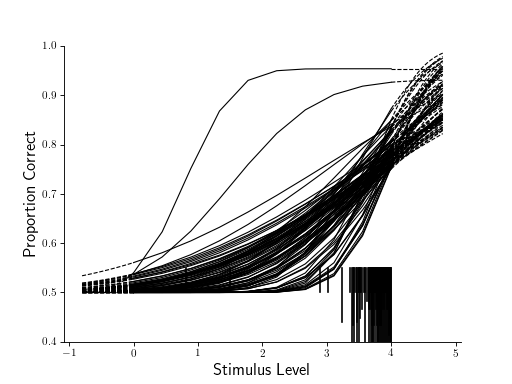

In [717]:
va='Lm'

fig, ax = pl.subplots()
for dk, est in pass_estimates[pass_estimates.visual_area==va].groupby(['datakey']):
    results = R[va][dk]
    curr_fit_cells = est['cell'].unique()
    for rid, res in results.items():
        if rid not in curr_fit_cells:
            continue
        ps.psigniplot.plotPsych(res, axisHandle=ax, plotData=False, lineWidth=1, plotAsymptote=False,
                               thresh_height=0.55, npoints=10)

<IPython.core.display.Javascript object>


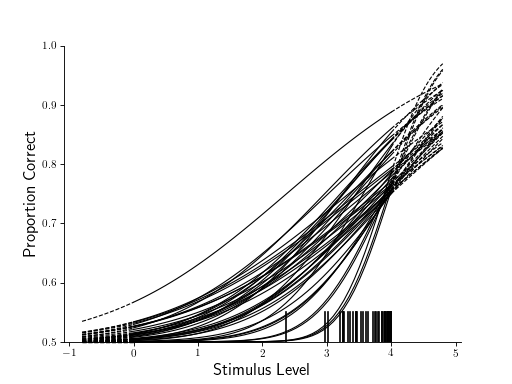

In [712]:
va='Li'

fig, ax = pl.subplots()
for dk, est in pass_estimates[pass_estimates.visual_area==va].groupby(['datakey']):
    results = R[va][dk]
    curr_fit_cells = est['cell'].unique()
    for rid, res in results.items():
        if rid not in curr_fit_cells:
            continue
        ps.psigniplot.plotPsych(res, axisHandle=ax, plotData=False, lineWidth=1, plotAsymptote=False,
                               thresh_height=0.55, npoints=50)

In [718]:
pass_estimates.head()

threshold     width        lambda  gamma           eta     slope  \
1    3.892998  1.914792  1.401999e-08    0.5  1.602869e-07  0.342701   
10   3.908429  3.619414  5.050646e-11    0.5  9.843335e-10  0.181301   
11   3.473057  7.589552  4.058454e-09    0.5  6.106602e-09  0.086461   
12   3.524935  7.561378  1.453119e-08    0.5  3.145398e-10  0.086783   
13   3.904229  5.447926  6.400028e-08    0.5  2.762301e-11  0.120450   

         thr  cell visual_area              datakey  
1   3.892998   261          Li  20190422_JC076_fov1  
10  3.908429    37          Li  20190602_JC091_fov1  
11  3.473057    38          Li  20190602_JC091_fov1  
12  3.524935    39          Li  20190602_JC091_fov1  
13  3.904230    40          Li  20190602_JC091_fov1

In [10]:
mean_est = pass_estimates.groupby(['visual_area', 'datakey']).mean().reset_index()

<IPython.core.display.Javascript object>


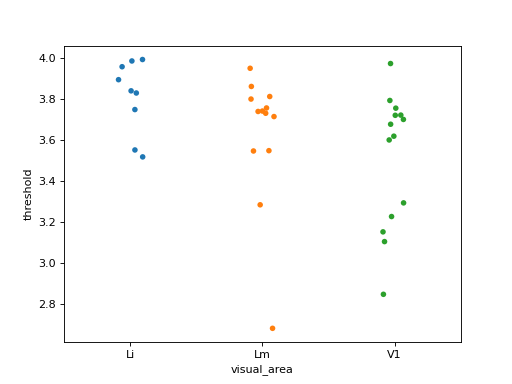

<AxesSubplot:xlabel='visual_area', ylabel='threshold'>

In [11]:
fig, ax = pl.subplots()
sns.stripplot(x='visual_area', y='threshold', data=mean_est, ax=ax)

<IPython.core.display.Javascript object>


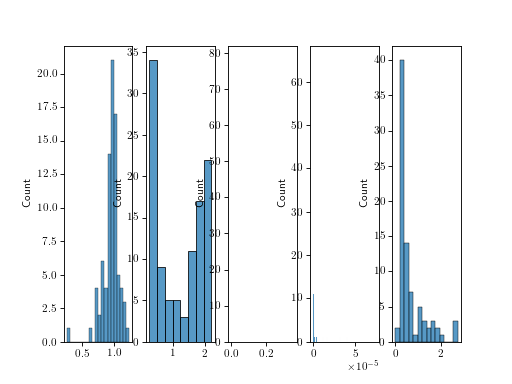

In [371]:
fig, axn = pl.subplots(1, n_params)
for ax, p in zip(axn.flat, ['threshold', 'width', 'lambda', 'eta', 'slope']):
    sns.histplot(data=estimates[p].values, ax=ax)



# Stimuli

In [40]:
morphlevels = SDF['20190616_JC097_fov1']['morphlevel'].unique()
stimdir = '/n/coxfs01/behavior-data/stimuli/D1D2M105_yrot_fine_steps/final'
curr_morphs = [m for m in sorted(morphlevels) if m!=-1]

image_fns = [os.path.join(stimdir, 'morph%i_y0.png' % m) for m in curr_morphs]
images={}
for m, fn in zip(curr_morphs, image_fns):
    images[m] = pl.imread(fn)

In [45]:
morph_lut, a_morphs, b_morphs = get_morph_levels()


In [46]:
morph_steps={}
for k, v in morph_lut.items():
    if v not in morph_steps.keys():
        morph_steps[v] =[]
    morph_steps[v].append(k)
morph_steps

{1: [40, 66], 2: [27, 79], 3: [14, 92], 4: [0, 106], 0: [53], -1: [-1]}

In [47]:
morphsteps = sorted([k for k, v in morph_steps.items() if k>=0])
morphsteps

[0, 1, 2, 3, 4]

<IPython.core.display.Javascript object>


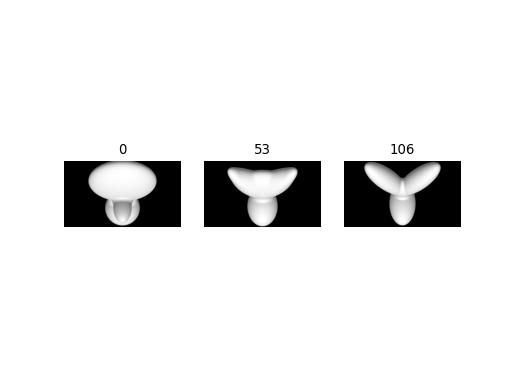

In [48]:
fig, axn = pl.subplots(1,3)
for ax, m in zip(axn.flat, [0, 53, 106]):
    ax.imshow(images[m], cmap='gray')
    ax.set_title(m)
    ax.axis('off')

<IPython.core.display.Javascript object>


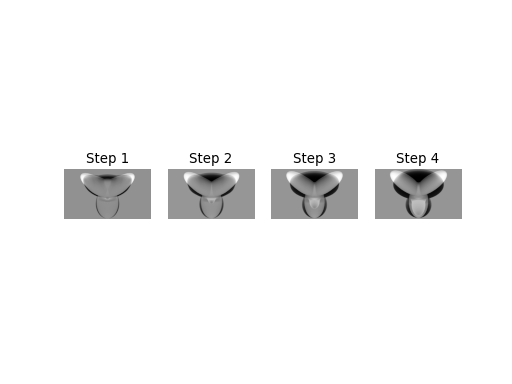

In [51]:
fig, axn = pl.subplots(1, len(morphsteps)-1)
diffs = {}
d=[]
for mstep, mims in morph_steps.items():
    if mstep <=0:
        continue
    ai = mstep-1
    ax = axn[ai]
    im1 = images[mims[0]]
    im2 = images[mims[1]] 
    diff_im = im1 - im2
    ax.imshow(diff_im, cmap='Greys')
    ax.axis('off')
    d.append(np.sum(diff_im))
    
    ediff = sp.spatial.distance.euclidean(im1.ravel(), im2.ravel())
    
    diffs[mstep] = ediff
    ax.set_title("Step %i" % mstep)
diffs.update({0: 0})


<IPython.core.display.Javascript object>


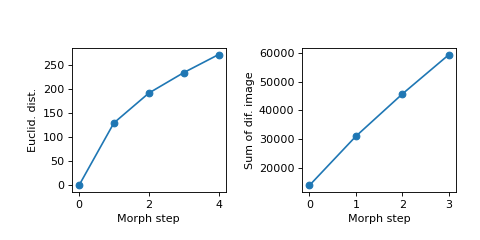

In [56]:
fig, axn = pl.subplots(1,2, figsize=(6,3))
ax=axn[0]
ax.plot(morphsteps, [diffs[v] for v in morphsteps], marker='o')
ax.set_xlabel('Morph step')
ax.set_ylabel('Euclid. dist.')

ax=axn[1]
ax.plot(d, marker='o')
ax.set_xlabel('Morph step')
ax.set_ylabel('Sum of dif. image')

pl.subplots_adjust(left=0.15, right=0.95, bottom=0.2, wspace=0.5, top=0.8)


In [620]:
diffs

{1: 129.56948852539062,
 2: 191.359619140625,
 3: 233.80543518066406,
 4: 271.2908630371094}

In [625]:
np.linalg.norm(im2-im1)

271.29086

<IPython.core.display.Javascript object>


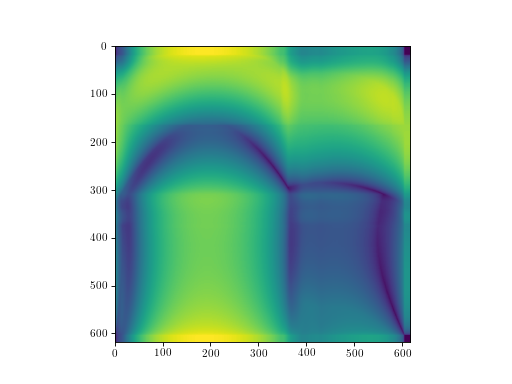

In [630]:
d1 = sp.spatial.distance.cdist(im2, im1, 'euclidean')
pl.figure()
pl.imshow(d1)

In [636]:
np.sum(diff_im)


-59371.383

In [343]:
pd.DataFrame(res['Fit'], index=param_names, columns=[rid]).T


threshold     width        lambda  gamma           eta
217   0.807907  0.688368  1.084300e-09    0.5  2.040462e-07

In [323]:
rid = 217

auc_r = best_auc[(best_auc['cell']==rid)].copy()
data = data_matrix_from_auc(auc_r)
data

array([[ 0.        , 14.        , 30.        ],
       [ 0.13207547, 17.        , 30.        ],
       [ 0.25471698, 18.        , 30.        ],
       [ 0.37735849, 15.        , 30.        ],
       [ 0.5       , 18.        , 30.        ],
       [ 0.62264151, 17.        , 30.        ],
       [ 0.74528302, 21.        , 30.        ],
       [ 0.86792453, 23.        , 30.        ],
       [ 1.        , 28.        , 30.        ]])

In [353]:
ps.getThreshold(res, 0.75)[0] # Value at which function reaches at_pc correct
ps.getSlope(res, ps.getThreshold(res, 0.75)[0]) # Slope at given stimulus level

/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


0.807906798155016

In [357]:
ps.getSlope(res, ps.getThreshold(res, 0.75)[0])

0.9532720278663362

<IPython.core.display.Javascript object>


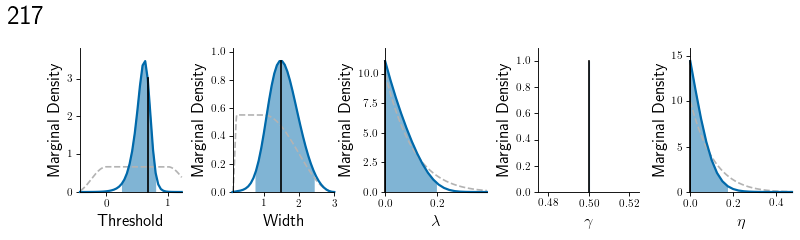

Error: The parameter you wanted to plot was fixed in the analysis!


/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py:324: UserWarning: Attempting to set identical left == right == 0.5 results in singular transformations; automatically expanding.
  plt.xlim([min(x), max(x)])


Text(0.01, 0.9, '217')

In [34]:
param_names = ['threshold', 'width', 'lambda', 'gamma', 'eta']
n_params = len(param_names)
fig, axn = pl.subplots(1, n_params, figsize=(10,3))

for pi, par in enumerate(param_names):
    ax=axn[pi]
    ax=ps.psigniplot.plotMarginal(res_, dim=pi, axisHandle=ax)
pl.subplots_adjust(left=0.1, right=0.99, bottom=0.2, wspace=0.5, top=0.8)

fig.text(0.01, 0.9, rid, fontsize=24)

# figname = 'marginals_%s' % animalid
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, figname)

<IPython.core.display.Javascript object>


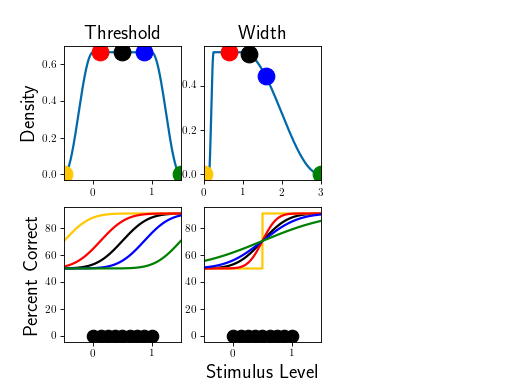

/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py:443: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,3,4)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py:445: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,3,1)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py:443: Ma

In [250]:
fig, ax = pl.subplots()
ps.psigniplot.plotPrior(res) #,axisHandle=ax)